In [2]:
import uproot,scipy,time
import numpy as np, pandas as pd,awkward as ak
from scipy.constants import golden
import matplotlib as mpl, matplotlib.patches as patches, matplotlib.pylab as plt
from scipy.optimize import curve_fit
from scipy.stats import norm


#presets for plot style
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
rc = plt.rc

rc('text', usetex=False)

rc('font', family='serif')
rc('font', size=18)

rc('xtick', labelsize=18)
rc('ytick', labelsize=18)

rc('axes', labelsize=18)
rc('legend', fontsize=18)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def Landau(x, location,fwhm,renormalization):
    #print(type(x))
    u=(x-location)*4/fwhm
    renormalization = 8/5*renormalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def Landau2(xs,location,fwhm,renormalization):
    if "array" in str(type(xs)) or "list" in str(type(xs)):
        linapprox=[]
        for x in xs:
            u=(x-location)/fwhm
            if u < -3.8 or u > 500: linapp = 0
            else:
                for i in range(len(LandauXs)):
                    if LandauXs[i] < u: index = i
                    else: break
                linapp = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
            linapprox.append(linapp)
    else:
        u=(xs-location)/fwhm
        if u < -3.8 or u > 500: linapprox = 0
        else:
            for i in range(len(LandauXs)):
                if LandauXs[i] < u: index = i
                else: break

            linapprox = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
    return linapprox

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)


In [3]:
toc = time.perf_counter_ns()
nEnergies = [1.7,3.2,5.1,7.1,9.1]
files = []
for n in nEnergies:
    files.append(f"../out_{n}.root")
fADC_ord = [-666]*len(nEnergies)
layers,event_hits,components = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)
ADCR_times,ADCL_times,ADCR_vals,ADCL_vals,TDCR_vals,TDCL_vals = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)
Edeps,avg_xs,avg_ys,avg_zs,avg_ts,gpx,gpy,gpz,eventn = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)

for i in range(len(nEnergies)):
    print(f"Working on {files[i]}...")
    f=uproot.open(files[i])
    fcal=f["fcal"]
    header = f["header"]
    generated = f["generated"]
    
    fADC_ord[i] = fcal["ADC_order"].array()
    
    layers[i] = fcal["layer"].array()[fADC_ord[i] == 0]
    
    event_hits[i] = ak.count(layers[i],-1)

    components[i] = fcal["component"].array()[fADC_ord[i] == 0]

    ADCR_times[i] = fcal["ADC_time"].array()[fADC_ord[i] == 0]
    ADCL_times[i] = fcal["ADC_time"].array()[fADC_ord[i] == 1]

    ADCR_vals[i] = fcal["ADC_ADC"].array()[fADC_ord[i] == 0]
    ADCL_vals[i] = fcal["ADC_ADC"].array()[fADC_ord[i] == 1]

    TDCR_vals[i] = fcal["TDC_TDC"].array()[fADC_ord[i] == 0]
    TDCL_vals[i] = fcal["TDC_TDC"].array()[fADC_ord[i] == 1]

    Edeps[i] = fcal["totEdep"].array()[fADC_ord[i] == 0]
    avg_xs[i] = fcal["avg_x"].array()[fADC_ord[i] == 0]
    avg_ys[i] = fcal["avg_y"].array()[fADC_ord[i] == 0]
    avg_zs[i] = fcal["avg_z"].array()[fADC_ord[i] == 0]
    avg_ts[i] = fcal["avg_t"].array()[fADC_ord[i] == 0]

    gpx[i] = generated["px"].array()
    gpy[i] = generated["py"].array()
    gpz[i] = generated["pz"].array()
    eventn[i] = header["evn"].array()
    
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

Working on ../out_1.7.root...
Working on ../out_3.2.root...
Working on ../out_5.1.root...
Working on ../out_7.1.root...
Working on ../out_9.1.root...
Time: 3836.5 ms per file


In [4]:
MIP = 875
minGeoMean=MIP/4
MIPcut=[-666]*len(nEnergies)
hitscutoff = [8,16,29,41,48] #hit cutoffs selected to maximize the product of resolution and efficiency
hitscut=[-666]*len(nEnergies)
event_MIPhits=[-666]*len(nEnergies)
ADCs=[-666]*len(nEnergies)
toc = time.perf_counter_ns()
for i in range(len(nEnergies)):
    print(f"Working on out_{nEnergies[i]}.root...")
    ADCs[i] = np.sqrt(ADCR_vals[i]*ADCL_vals[i])
    MIPcut[i] = ADCs[i] > minGeoMean
    event_MIPhits[i] = ak.count(layers[i][MIPcut[i]],-1)
    hitscut[i] = event_MIPhits[i] > hitscutoff[i]

tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

Working on out_1.7.root...
Working on out_3.2.root...
Working on out_5.1.root...
Working on out_7.1.root...
Working on out_9.1.root...
Time: 21.5 ms per file


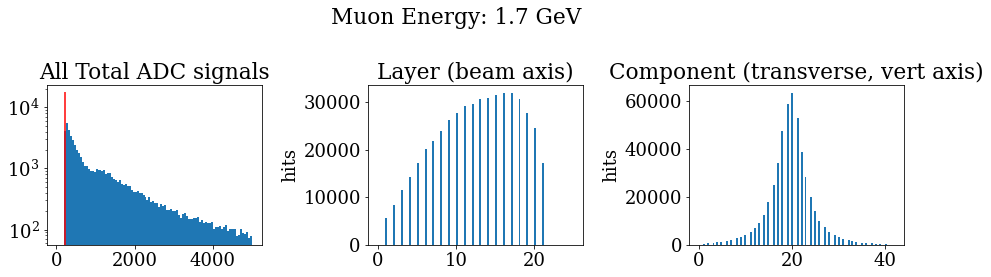

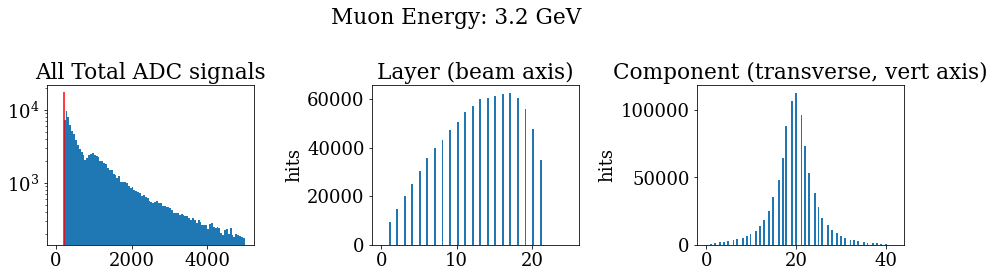

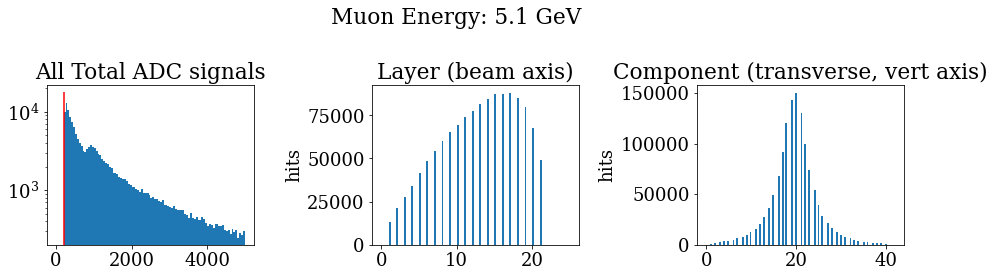

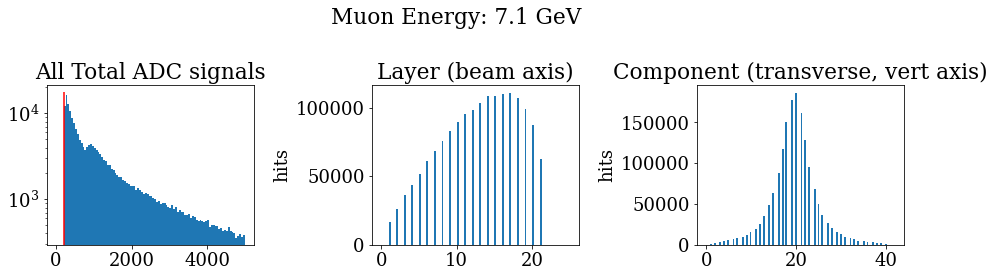

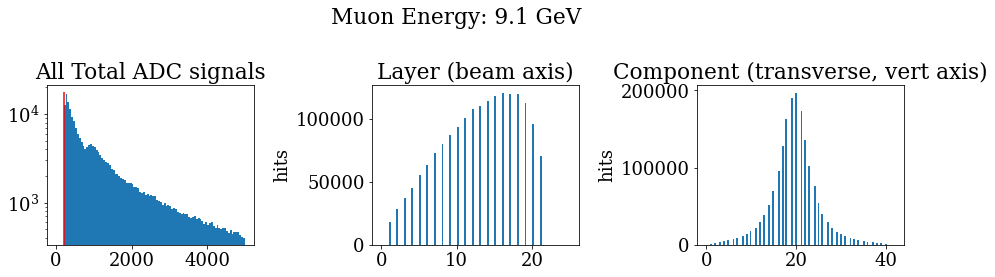

In [5]:
for i in range(len(nEnergies)): 
    fig,ax = plt.subplots(1,3,figsize=(13,4))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    ax[0].set_title("All Total ADC signals")
    ax[0].hist(ak.flatten(ADCs[i][MIPcut[i]]),bins=100,range=(0,5000),log=1)
    ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
    ax[1].set_title("Layer (beam axis)")
    ax[1].set_ylabel("hits")
    ax[1].hist(ak.flatten(layers[i]),bins=100,range=(0,25))
    ax[2].set_title("Component (transverse, vert axis)")
    ax[2].set_ylabel("hits")
    ax[2].hist(ak.flatten(components[i]),bins=100,range=(0,42))
    plt.show()

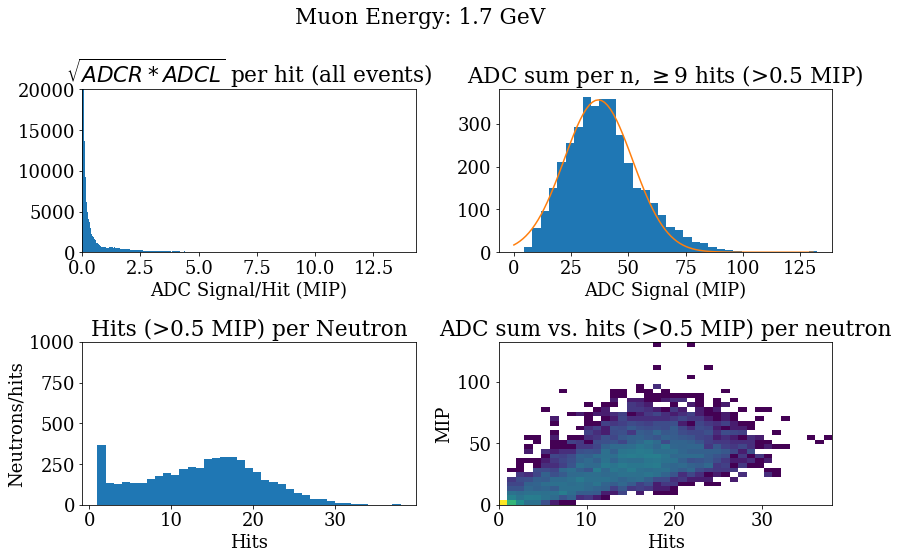

Average Energy Deposition: 36.87 GeV,     Energy Deposition stdev: 14.94 GeV
Energy Resolution: 0.41
Calorimeter Efficiency for at least 1 hit (>0.5 MIP): 50.8%
Calorimeter Efficiency for at least 9 hits (>0.5 MIP): 37.0%
Quality: 0.912



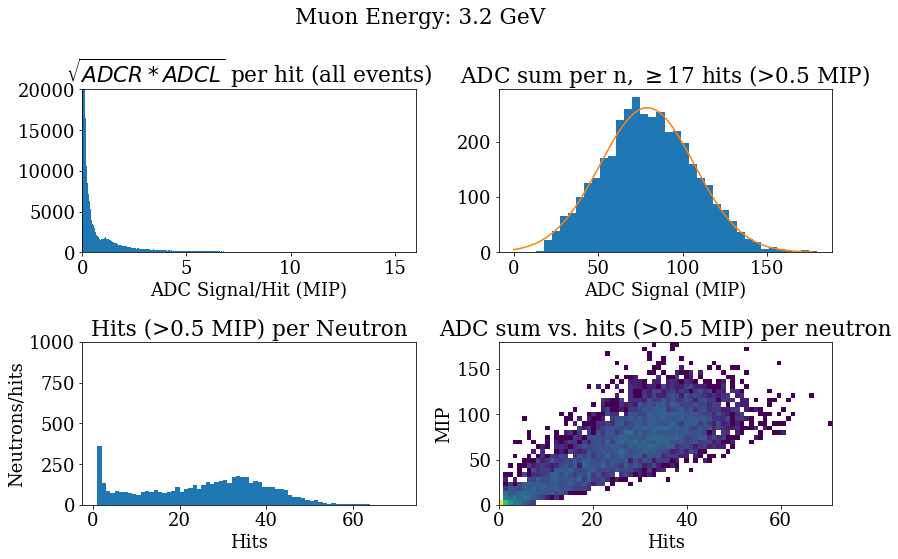

Average Energy Deposition: 79.06 GeV,     Energy Deposition stdev: 27.97 GeV
Energy Resolution: 0.35
Calorimeter Efficiency for at least 1 hit (>0.5 MIP): 53.9%
Calorimeter Efficiency for at least 17 hits (>0.5 MIP): 38.1%
Quality: 1.078



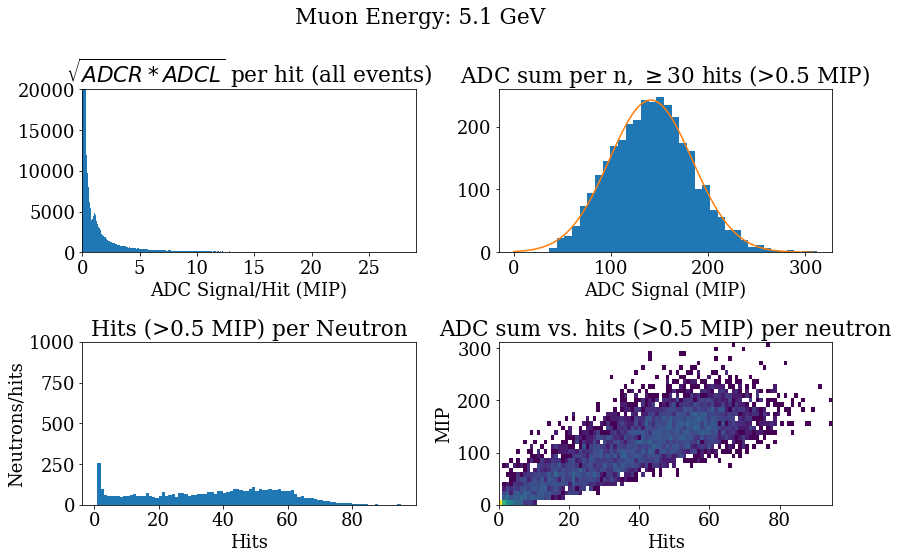

Average Energy Deposition: 140.87 GeV,     Energy Deposition stdev: 42.72 GeV
Energy Resolution: 0.30
Calorimeter Efficiency for at least 1 hit (>0.5 MIP): 52.0%
Calorimeter Efficiency for at least 30 hits (>0.5 MIP): 32.7%
Quality: 1.080



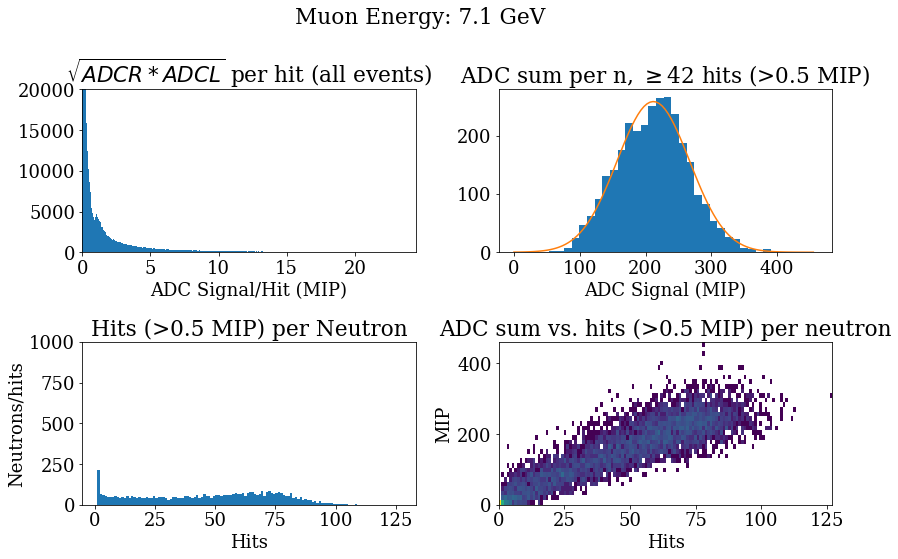

Average Energy Deposition: 211.83 GeV,     Energy Deposition stdev: 55.00 GeV
Energy Resolution: 0.26
Calorimeter Efficiency for at least 1 hit (>0.5 MIP): 51.0%
Calorimeter Efficiency for at least 42 hits (>0.5 MIP): 30.3%
Quality: 1.169



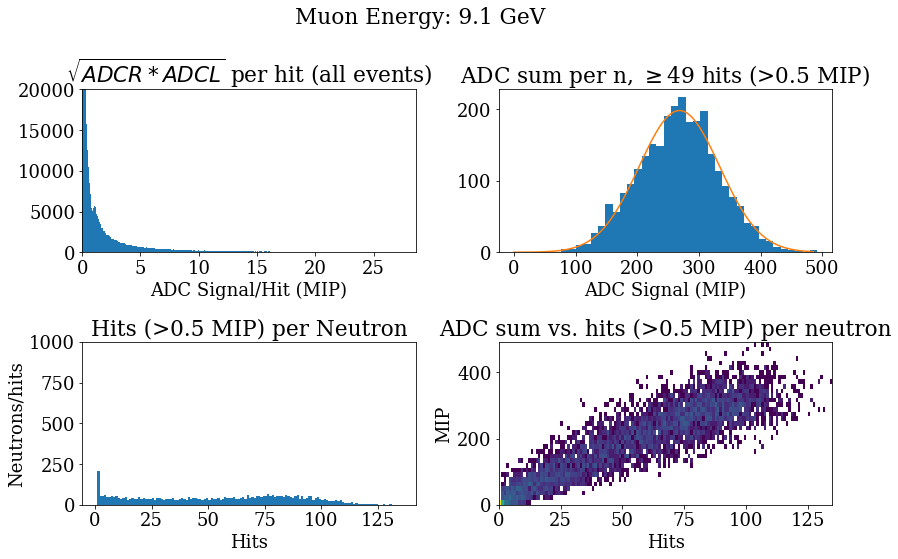

Average Energy Deposition: 268.39 GeV,     Energy Deposition stdev: 65.15 GeV
Energy Resolution: 0.24
Calorimeter Efficiency for at least 1 hit (>0.5 MIP): 50.1%
Calorimeter Efficiency for at least 49 hits (>0.5 MIP): 28.4%
Quality: 1.171



In [6]:
for i in range(len(nEnergies)):
    fig,ax = plt.subplots(2,2,figsize=(12,8))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    
    ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
    ax[0][0].hist(ak.flatten(ADCs[i])/MIP,2000)
    ax[0][0].set_xlabel("ADC Signal/Hit (MIP)")
    ax[0][0].set_xlim(0,np.max(ADCs[i])/MIP/5)
    ax[0][0].set_ylim(0,20000)

    ax[0][1].set_title(f"ADC sum per n, $\\geq${hitscutoff[i]+1} hits (>0.5 MIP)")
    count,binedges,bars=ax[0][1].hist(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1)/MIP,35)
    ax[0][1].set_xlabel("ADC Signal (MIP)")

    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, count,p0=(2000,30,10))

    ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

    ax[1][0].set_title("Hits (>0.5 MIP) per Neutron")
    count,bins,bars=ax[1][0].hist(event_MIPhits[i][event_MIPhits[i] > hitscut[i]],np.max(event_MIPhits[i])-np.min(event_MIPhits[i])-1)
    ax[1][0].set_xlabel("Hits")
    ax[1][0].set_ylabel("Neutrons/hits")
    ax[1][0].set_ylim(0,1000)

    ax[1][1].hist2d(event_MIPhits[i].tolist(),ak.sum(ADCs[i][MIPcut[i]]/MIP,-1).tolist(),bins=[np.max(event_MIPhits[i])-np.min(event_MIPhits[i])+1,35],cmin=1,norm=mpl.colors.LogNorm())
    ax[1][1].set_title("ADC sum vs. hits (>0.5 MIP) per neutron")
    ax[1][1].set_xlabel("Hits")
    ax[1][1].set_ylabel("MIP")
    
    plt.show()

    efficiency1=ak.count_nonzero(event_MIPhits[i])/ak.count(event_MIPhits[i])
    hitscut[i] = event_MIPhits[i] > hitscutoff[i]
    efficiency=ak.count(event_MIPhits[i][hitscut[i]])/ak.count(event_MIPhits[i])
    print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
    print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
    print(f"Calorimeter Efficiency for at least 1 hit (>0.5 MIP): {efficiency1*100:.1f}%")
    print(f"Calorimeter Efficiency for at least {hitscutoff[i]+1:.0f} hits (>0.5 MIP): {efficiency*100:.1f}%")
    print(f"Quality: {efficiency/(abs(coeff[2])/coeff[1]):.3f}")
    print("")

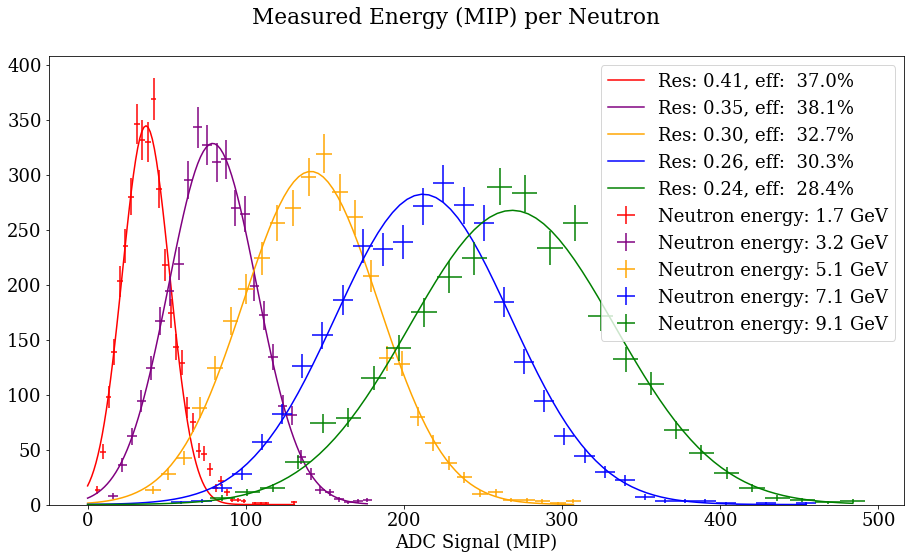

In [7]:
fig,ax = plt.subplots(1,1,figsize=(13,8))
fig.suptitle(f"Measured Energy (MIP) per Neutron")
colors = ["red","purple","orange","blue","green"]
for i in range(len(nEnergies)):
    

    
    stdev = np.sqrt(ak.mean(np.power(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1)/MIP-ak.mean(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1))/MIP,2)))
    datarange = ak.max(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1))/MIP-ak.min(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1))/MIP
    
    count,binedges,bars=ax.hist(ak.sum(ADCs[i][MIPcut[i]][hitscut[i]],-1)/MIP,int(np.ceil(datarange*np.power(ak.num(ADCs[i][MIPcut[i]][hitscut[i]],0),1/3)/(3.49*stdev))),visible=False)
    bincenters = binedges[1:]/2+binedges[:-1]/2
    plt.errorbar(bincenters,count,xerr=(bincenters[1]-bincenters[0])*0.5,yerr=np.sqrt(count),color=colors[i],linestyle="",label=f"Neutron energy: {nEnergies[i]} GeV")
    
    
    
    coeff, covar = curve_fit(gaus, bincenters, count,p0=(2000,30,10))
    
    efficiency1=ak.count_nonzero(event_MIPhits[i])/ak.count(event_MIPhits[i])
    hitscut[i] = event_MIPhits[i] > hitscutoff[i]
    efficiency=ak.count(event_MIPhits[i][hitscut[i]])/ak.count(event_MIPhits[i])
    
    ax.plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),color=colors[i],label=f"Res: {abs(coeff[2])/coeff[1]:.2f}, eff:  {efficiency*100:.1f}%")
ax.set_xlabel("ADC Signal (MIP)")
ax.legend()
plt.show()

In [8]:
#import the x,y,z conversions from the muon data
posconversions = {'m_x': 0.5599579052657031,
 'b_x': -0.014550787265756898,
 'sigma_x': 16.559508318550947,
 'mu_x': -9.121242491578879e-15,
 'm_y': 0.01917100896305481,
 'b_y': 42.45987828836007,
 'sigma_y': 14.798516077987014,
 'mu_y': -3.4553105977064795e-13,
 'm_z': 0.021368451383197165,
 'b_z': -277.5922413147715,
 'sigma_z': 1.608809272684061,
 'mu_z': 2.780240677405443e-13}

m = 5.59958e-01,b = -1.45508e-02
mu = 0.00, sigma = 17.24


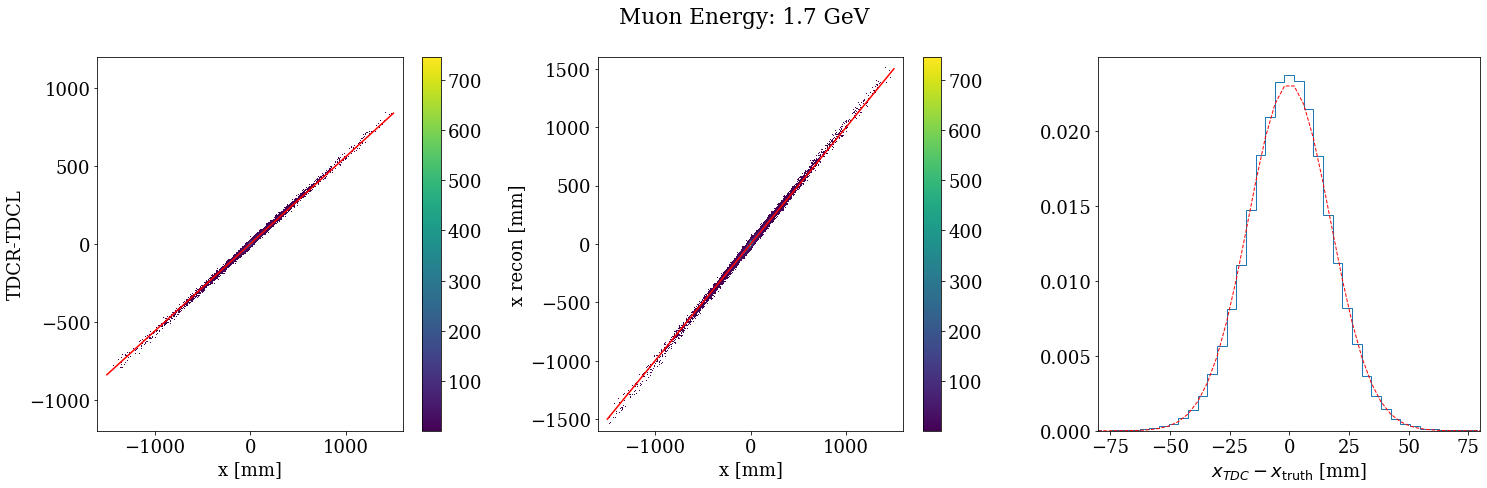

m = 5.59958e-01,b = -1.45508e-02
mu = 0.05, sigma = 17.05


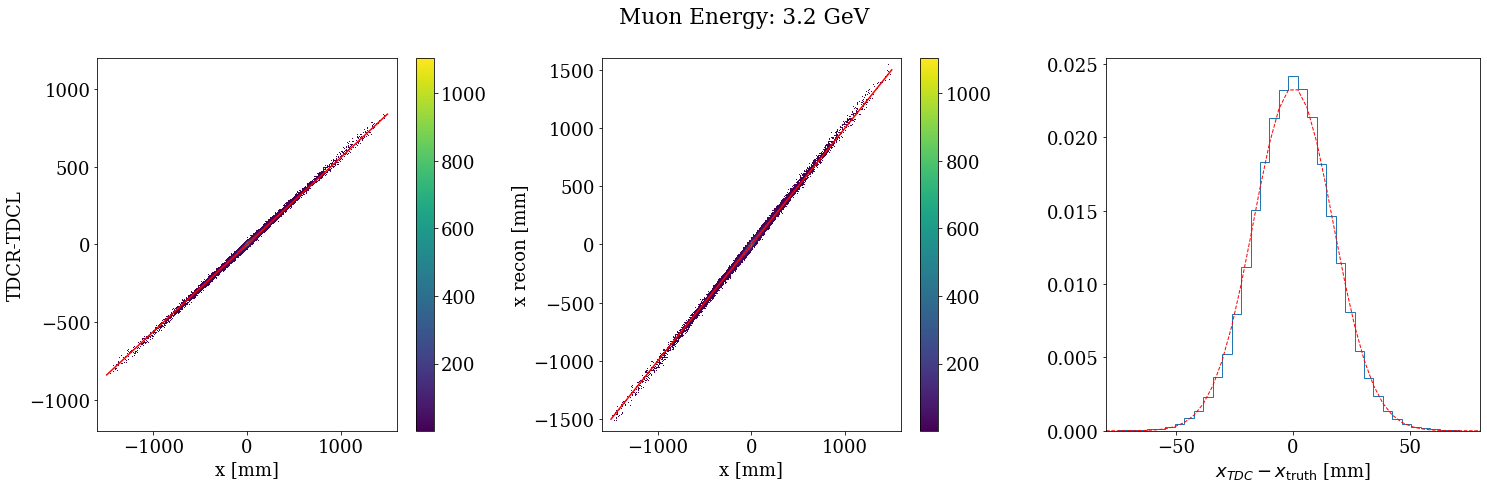

m = 5.59958e-01,b = -1.45508e-02
mu = -0.00, sigma = 17.18


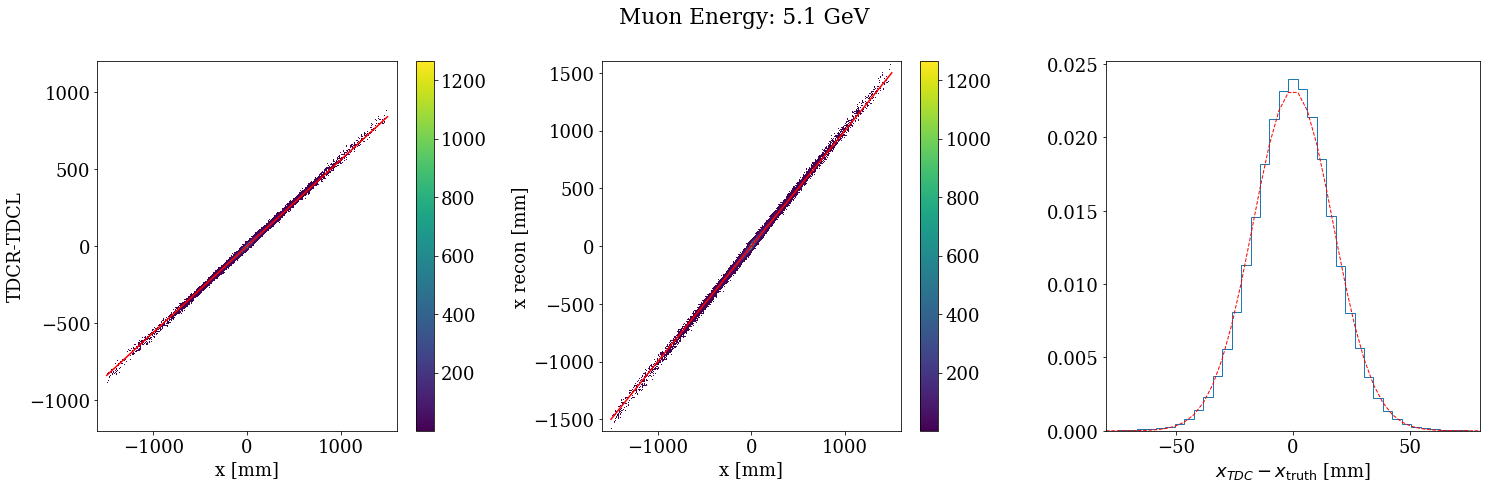

m = 5.59958e-01,b = -1.45508e-02
mu = -0.08, sigma = 17.00


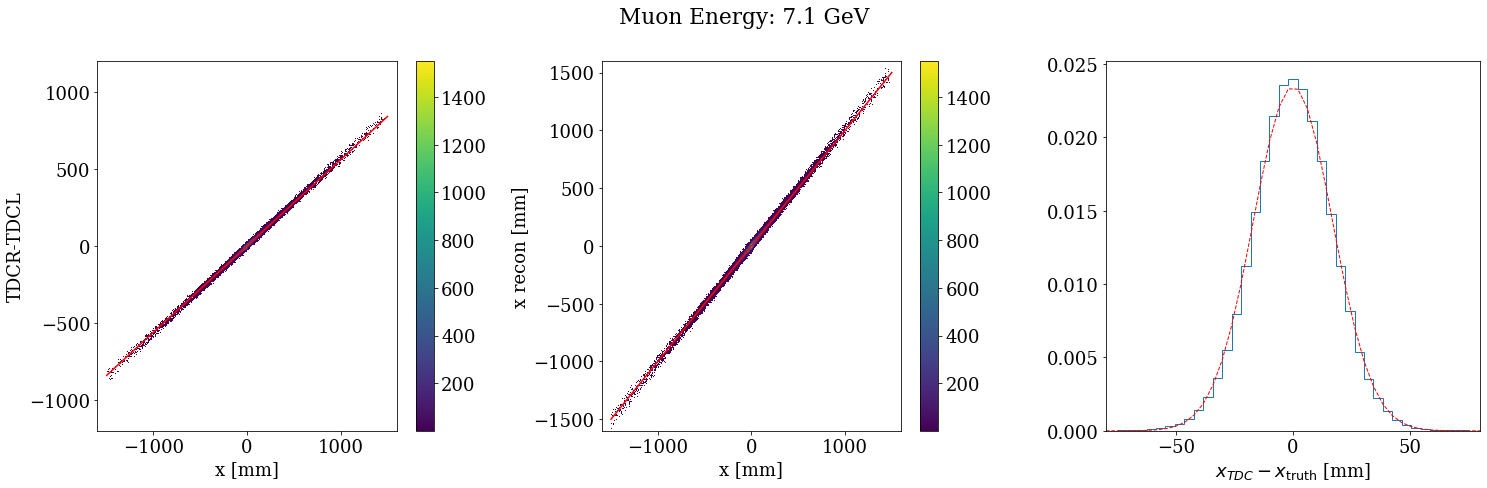

m = 5.59958e-01,b = -1.45508e-02
mu = -0.02, sigma = 17.03


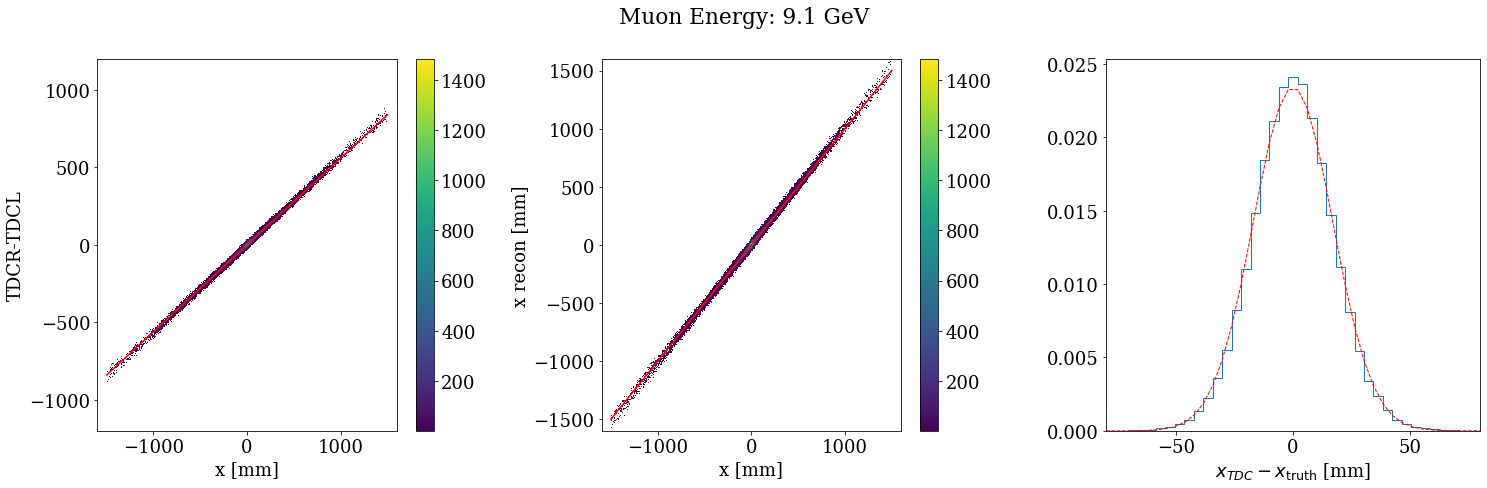

Time: 2245.1 ms per file


In [9]:
toc = time.perf_counter_ns()
results = [-666]*len(nEnergies)
for i in range(len(nEnergies)):
    x=avg_xs[i][MIPcut[i]][hitscut[i]]
    obs=(TDCR_vals[i][MIPcut[i]]-TDCL_vals[i][MIPcut[i]])[hitscut[i]]
    
    m = posconversions['m_x']
    b = posconversions['b_x']
    
    print(f"m = {m:.5e},b = {b:.5e}")
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    obsvy = ax[0].hist2d(ak.flatten(x).tolist(),ak.flatten(obs).tolist(),bins=[500,500],cmin=1)
    ax[0].set_xlim(-1600,1600)
    ax[0].set_ylim(-1200,1200)
    
    fig.colorbar(obsvy[-1],ax=ax[0])
    #plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[0].plot(xpt, m*xpt+b, linestyle="-",color="red")
    ax[0].set_xlabel("x [mm]")
    ax[0].set_ylabel("TDCR-TDCL")

    
    x_recon = (obs-b)/m
    results[i] = {"x_recon": x_recon}
    
    recvy = ax[1].hist2d(ak.flatten(x).tolist(),ak.flatten(x_recon).tolist(),bins=[500,500],cmin=1) #,norm=mpl.colors.LogNorm()
    fig.colorbar(recvy[-1],ax=ax[1])
    ax[1].set_xlim(-1600,1600)
    ax[1].set_ylim(-1600,1600)
    #plt.plot(x[:], x_recon[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[1].plot(xpt, xpt, linestyle="-",color="red")
    ax[1].set_xlabel("x [mm]")
    ax[1].set_ylabel("x recon [mm]")
    
    #now create a residual plot

    residuals= x-x_recon
    (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
    print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")
    # the histogram of the data
    n, bins, patches = ax[2].hist(ak.flatten(residuals), bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = ax[2].plot(bins, y, 'r--', linewidth=1)
    ax[2].set_xlim(-80,80)
    ax[2].set_xlabel(f"$x_{{TDC}}-x_{{\\rm truth}}$ [mm]")
    plt.show()
    
    results[i]["x_residual"] = residuals
    
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

m = 0.02,b = 42.46
mu = 0.33, sigma = 14.12


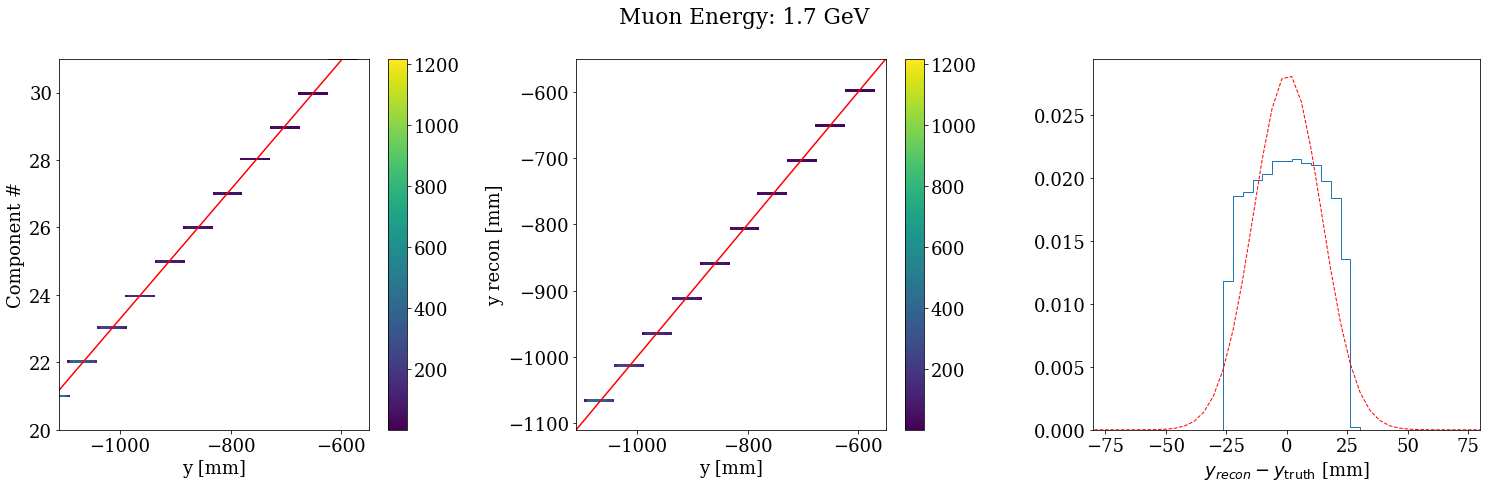

m = 0.02,b = 42.46
mu = 0.30, sigma = 13.68


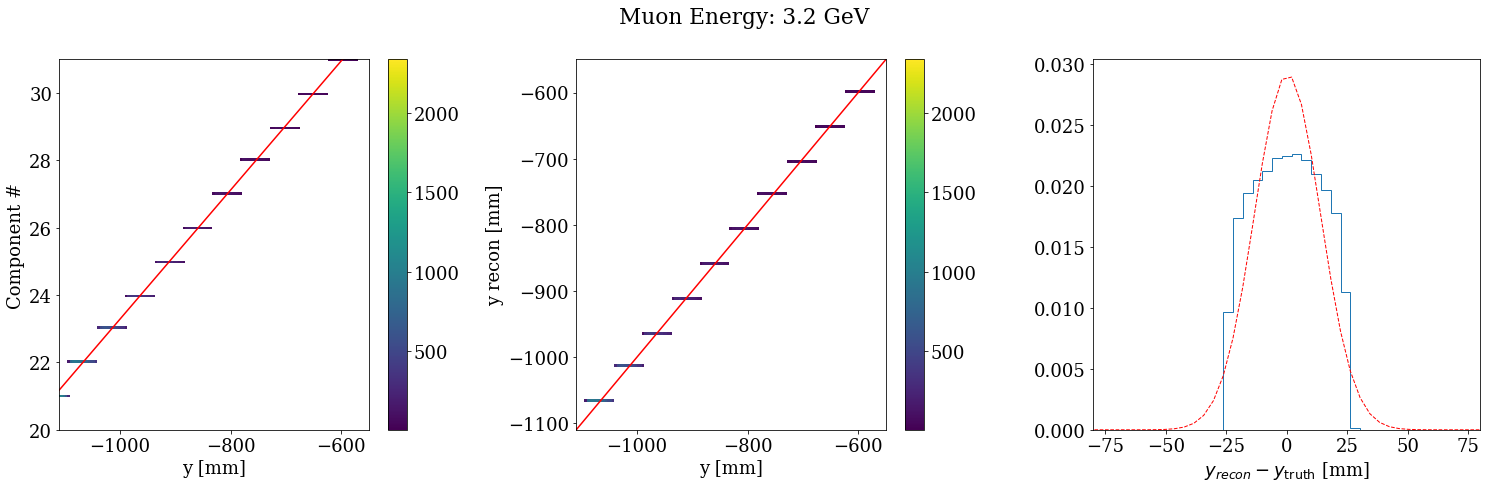

m = 0.02,b = 42.46
mu = 0.26, sigma = 13.28


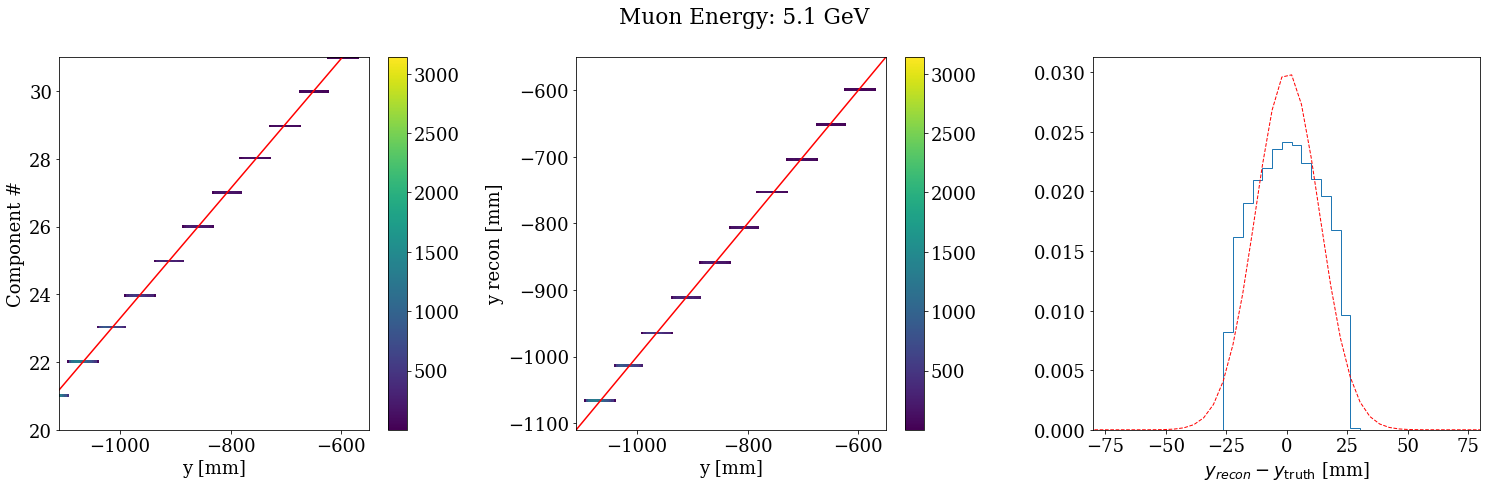

m = 0.02,b = 42.46
mu = 0.26, sigma = 13.00


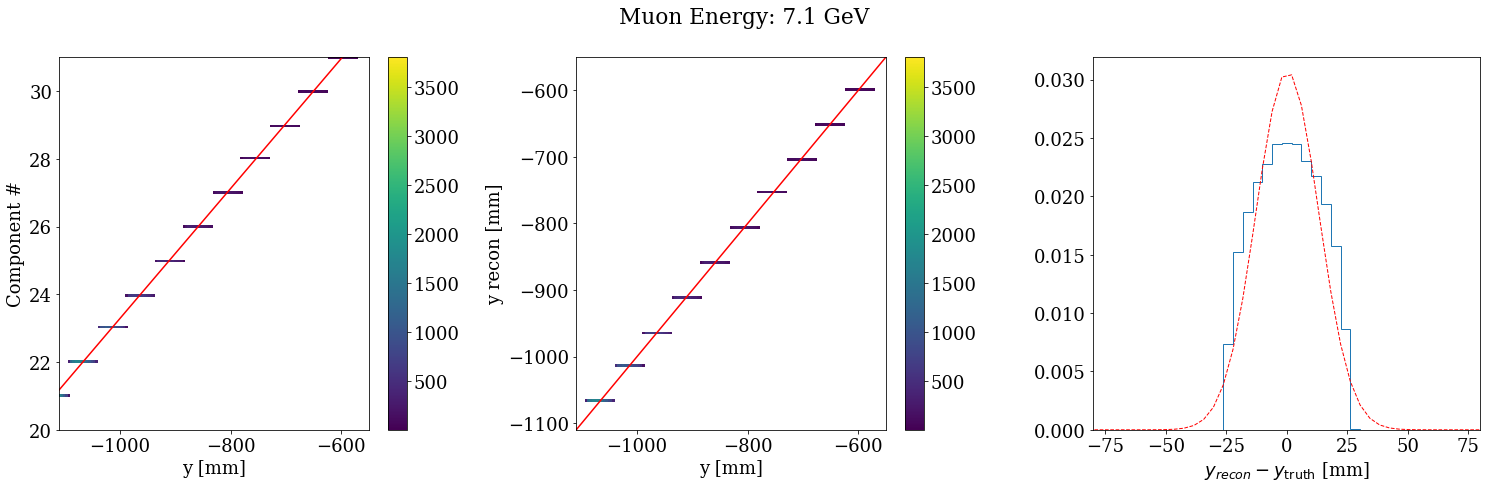

m = 0.02,b = 42.46
mu = 0.25, sigma = 12.71


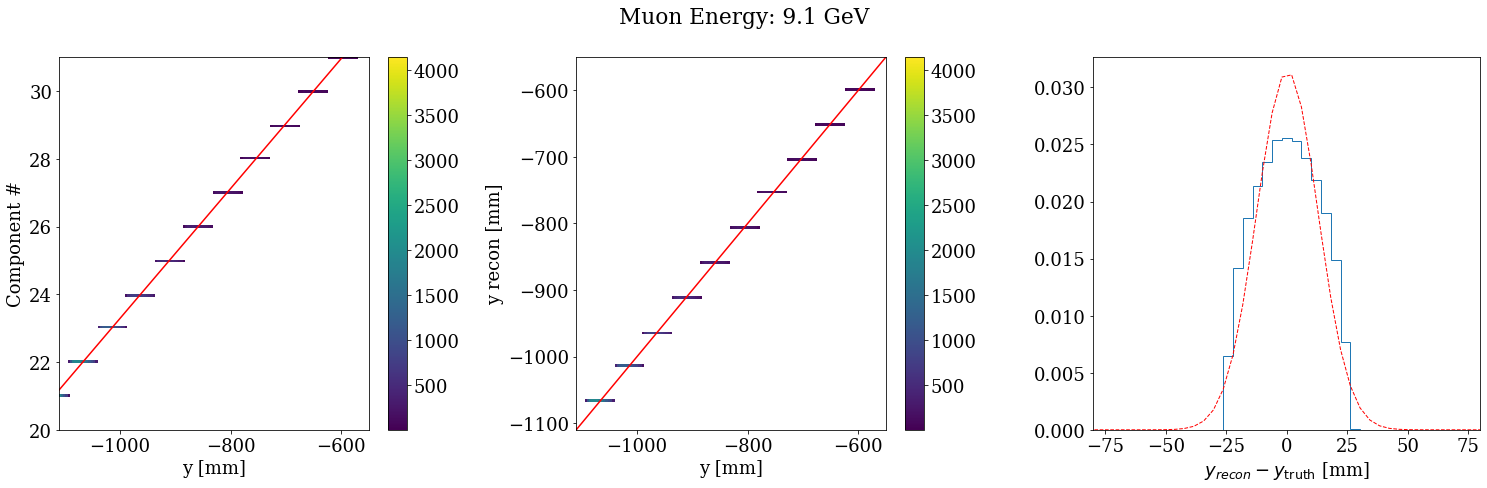

Time: 2003.2 ms per file


In [10]:
toc = time.perf_counter_ns()
for i in range(len(nEnergies)):
    y = (avg_ys[i][MIPcut[i]][hitscut[i]])
    obs=(components[i][MIPcut[i]][hitscut[i]])
    
    m = posconversions['m_y']
    b = posconversions['b_y']
    print(f"m = {m:.2f},b = {b:.2f}")
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    obsvy = ax[0].hist2d(ak.flatten(y).tolist(),ak.flatten(obs).tolist(),bins=[500,500],cmin=1)
    ax[0].set_xlim(-1110,-550)
    ax[0].set_ylim(20,31)
    fig.colorbar(obsvy[-1],ax=ax[0])
    #plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[0].plot(xpt, m*xpt+b, linestyle="-",color="red")
    ax[0].set_xlabel("y [mm]")
    ax[0].set_ylabel("Component #")

    
    y_recon = (obs-b)/m
    results[i]["y_recon"] = y_recon
    
    recvy = ax[1].hist2d(ak.flatten(y).tolist(),ak.flatten(y_recon).tolist(),bins=[500,500],cmin=1) #,norm=mpl.colors.LogNorm()
    fig.colorbar(recvy[-1],ax=ax[1])
    ax[1].set_xlim(-1110,-550)
    ax[1].set_ylim(-1110,-550)
    #plt.plot(x[:], x_recon[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[1].plot(xpt, xpt, linestyle="-",color="red")
    ax[1].set_xlabel("y [mm]")
    ax[1].set_ylabel("y recon [mm]")
    
    #now create a residual plot

    residuals= y-y_recon
    (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
    print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")
    # the histogram of the data
    n, bins, patches = ax[2].hist(ak.flatten(residuals), bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = ax[2].plot(bins, y, 'r--', linewidth=1)
    ax[2].set_xlim(-80,80)
    ax[2].set_xlabel(f"$y_{{recon}}-y_{{\\rm truth}}$ [mm]")
    plt.show()
    
    results[i]["y_residual"] = residuals
    
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

Time: -3.5 ms per file
m = 0.0214,b = -277.5922
mu = -3.09, sigma = 4.77


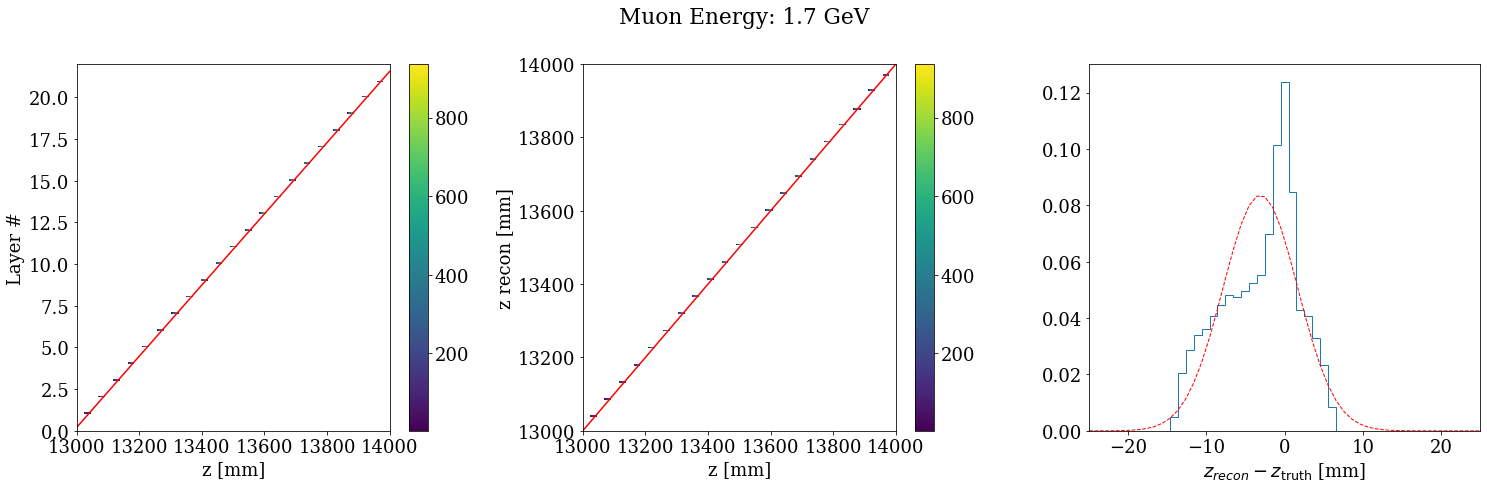

m = 0.0214,b = -277.5922
mu = -3.00, sigma = 4.54


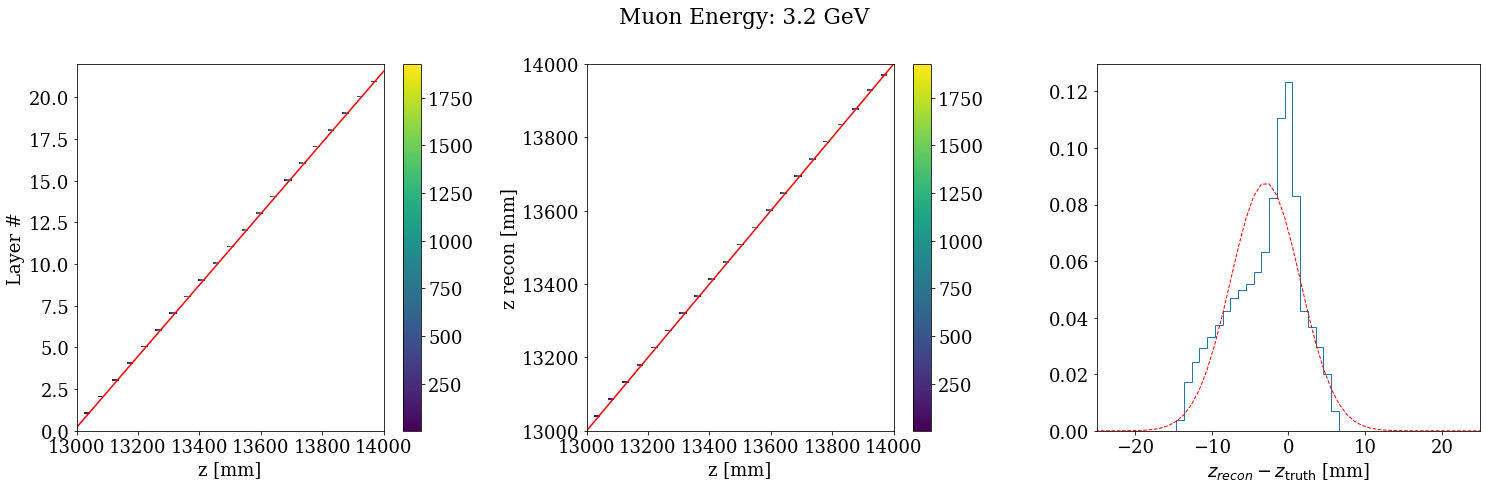

m = 0.0214,b = -277.5922
mu = -3.04, sigma = 4.43


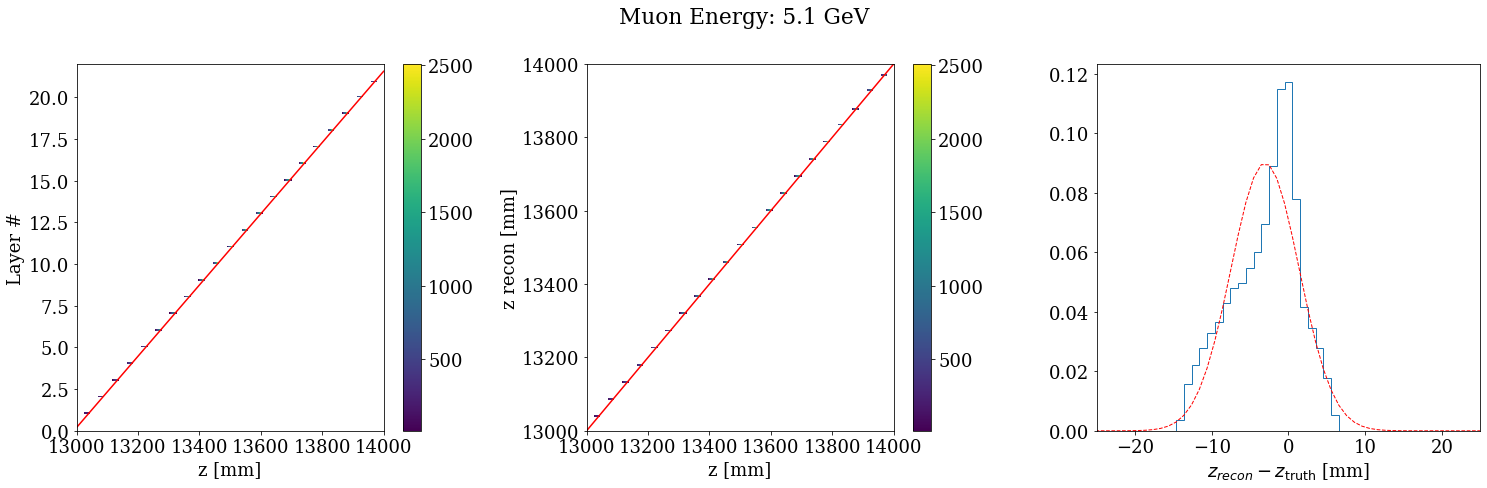

m = 0.0214,b = -277.5922
mu = -3.04, sigma = 4.35


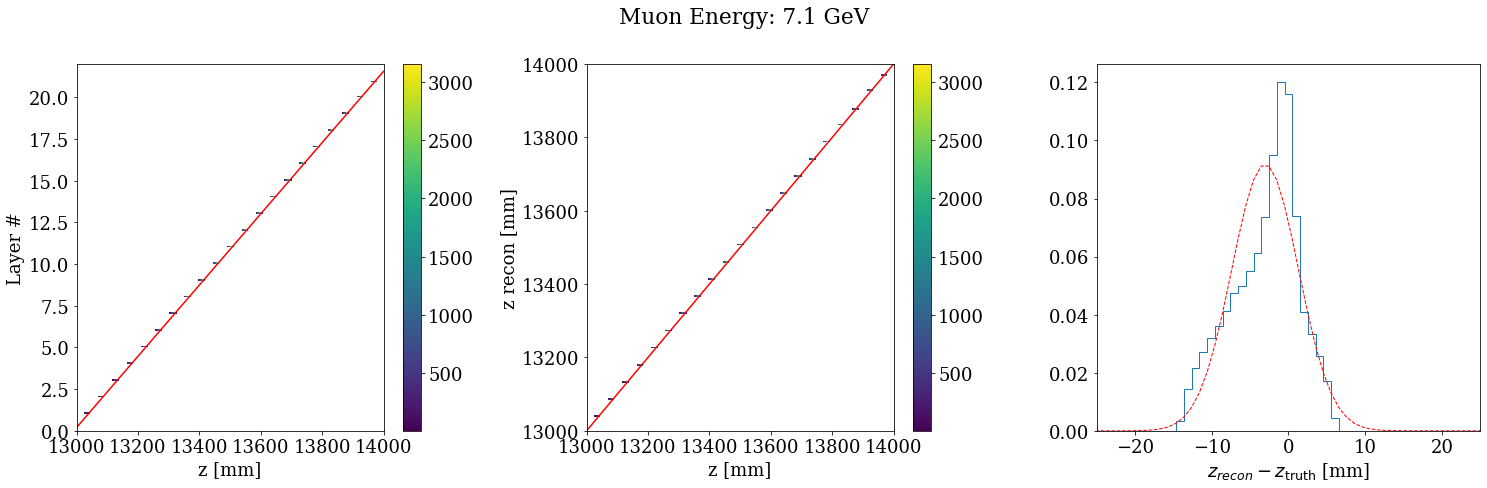

m = 0.0214,b = -277.5922
mu = -3.03, sigma = 4.26


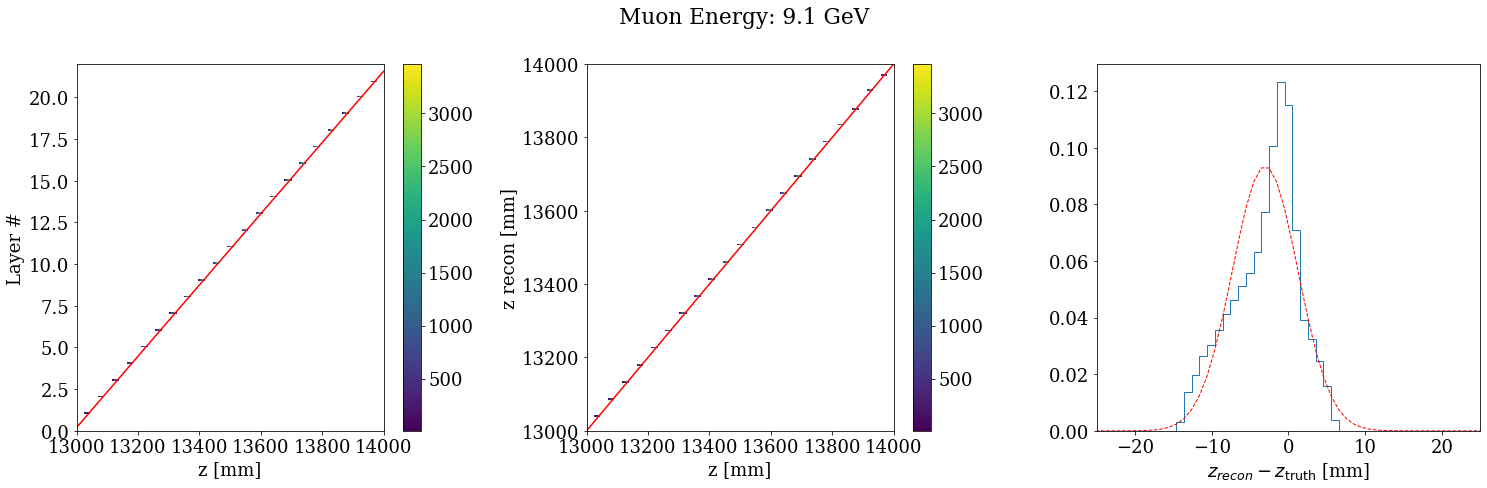

Time: 1926.9 ms per file


In [11]:
toc = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")
#reconstruct the z position
for i in range(len(nEnergies)):
    z = (avg_zs[i][MIPcut[i]][hitscut[i]])
    obs=(layers[i][MIPcut[i]][hitscut[i]])
    
    m = posconversions['m_z']
    b = posconversions['b_z']
    print(f"m = {m:.4f},b = {b:.4f}")
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    obsvz = ax[0].hist2d(ak.flatten(z).tolist(),ak.flatten(obs).tolist(),bins=[500,200],cmin=1)
    ax[0].set_xlim(13000,14000)
    ax[0].set_ylim(0,22)
    fig.colorbar(obsvz[-1],ax=ax[0])
    #plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([13000, 14000])
    #plt.xlim(-.2,.2)
    ax[0].plot(xpt, m*xpt+b, linestyle="-",color="red")
    ax[0].set_xlabel("z [mm]")
    ax[0].set_ylabel("Layer #")

    
    z_recon = (obs-b)/m
    results[i]["z_recon"] = z_recon
    
    recvz = ax[1].hist2d(ak.flatten(z).tolist(),ak.flatten(z_recon).tolist(),bins=[500,200],cmin=1) #,norm=mpl.colors.LogNorm()
    fig.colorbar(recvz[-1],ax=ax[1])
    ax[1].set_xlim(13000,14000)
    ax[1].set_ylim(13000,14000)
    #plt.plot(x[:], x_recon[:], marker='.', linestyle="")
    xpt = pd.Series([13000, 14000])
    #plt.xlim(-.2,.2)
    ax[1].plot(xpt, xpt, linestyle="-",color="red")
    ax[1].set_xlabel("z [mm]")
    ax[1].set_ylabel("z recon [mm]")
    
    #now create a residual plot

    residuals= z-z_recon
    (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
    print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")
    # the histogram of the data
    n, bins, patches = ax[2].hist(ak.flatten(residuals), bins=np.linspace(-50, 50, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = ax[2].plot(bins, y, 'r--', linewidth=1)
    ax[2].set_xlim(-25,25)
    ax[2].set_xlabel(f"$z_{{recon}}-z_{{\\rm truth}}$ [mm]")
    plt.show()
    
    results[i]["z_residual"] = residuals
    
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

In [13]:
results[0]

{'x_recon': <Array [[107, 382, -41, ... 213, 180, 391]] type='3696 * var * float64'>,
 'x_residual': <Array [[-19.9, 12.4, 16.4, ... -16.1, -0.881]] type='3696 * var * float64'>,
 'y_recon': <Array [[-1.17e+03, -1.17e+03, ... -1.38e+03]] type='3696 * var * float64'>,
 'y_residual': <Array [[-15.4, -12.2, -8.78, ... -7.18, -23]] type='3696 * var * float64'>,
 'z_recon': <Array [[1.35e+04, 1.36e+04, ... 1.36e+04]] type='3696 * var * float64'>,
 'z_residual': <Array [[-3.96, -4.09, -6.79, ... 2.34, -9.84]] type='3696 * var * float64'>}

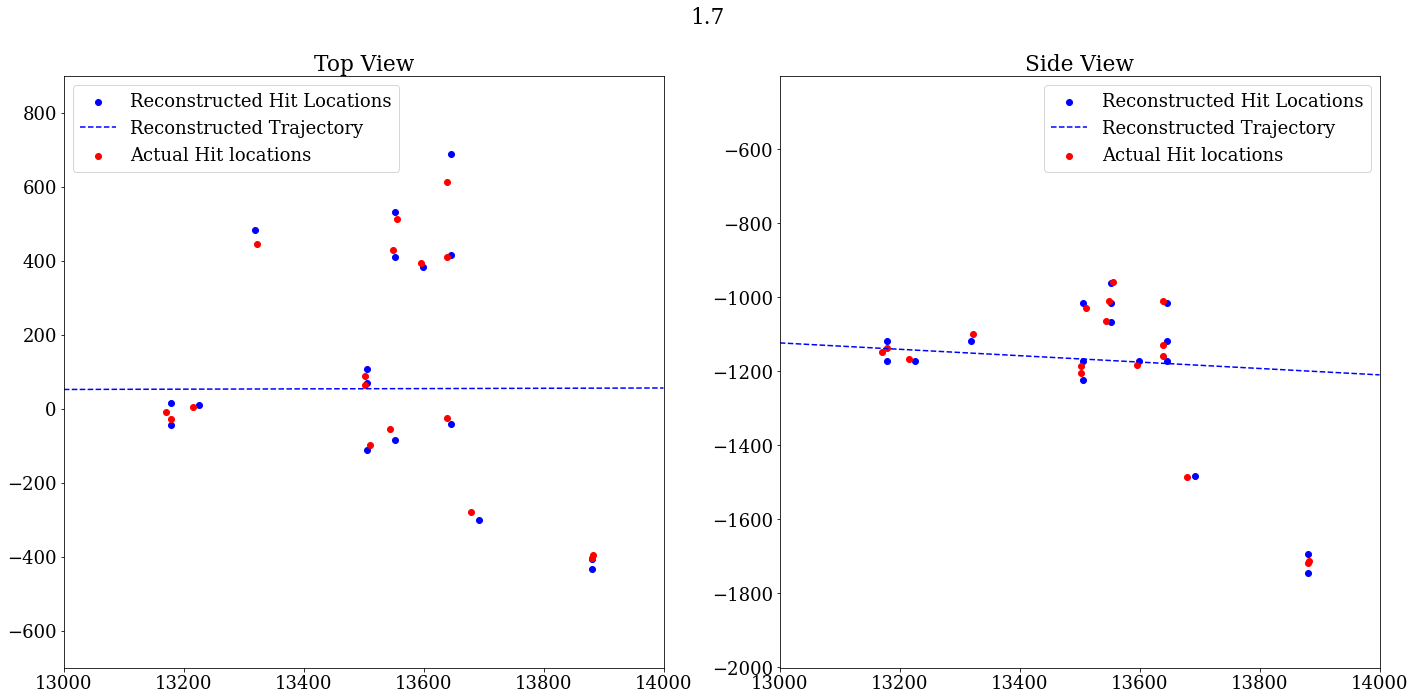

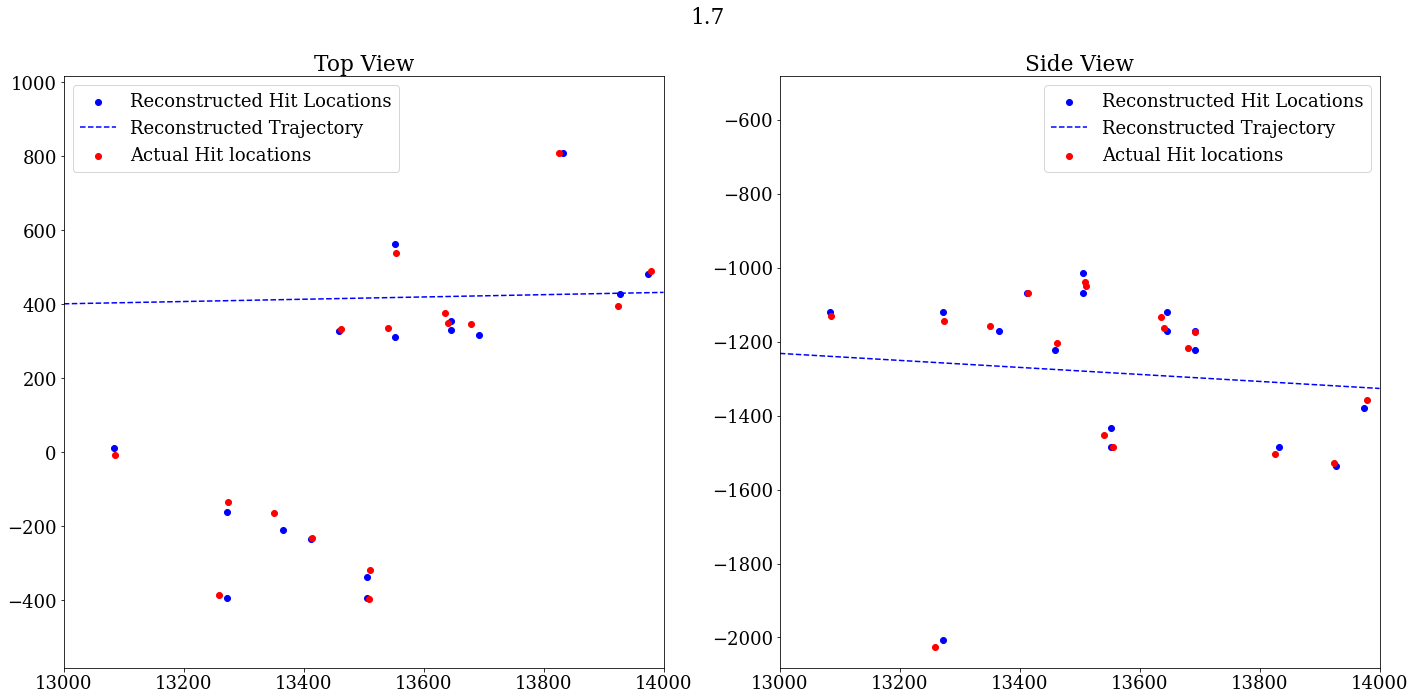

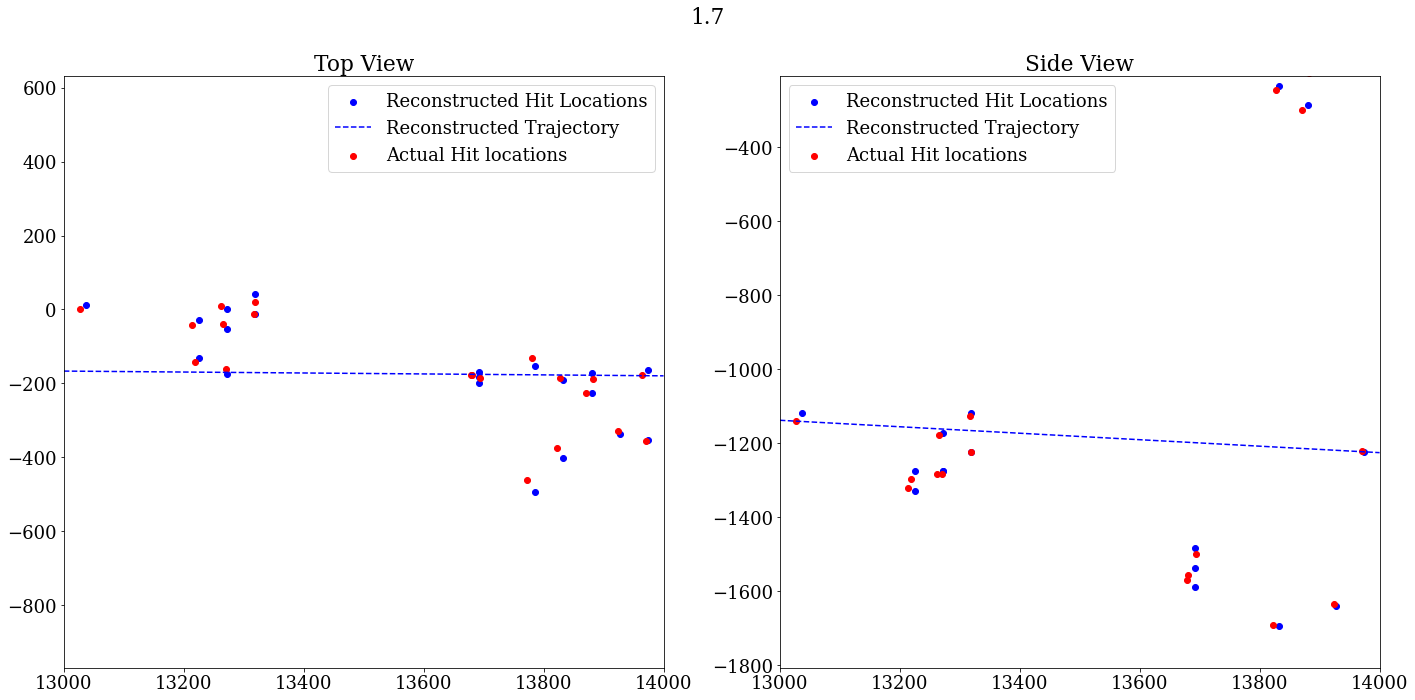

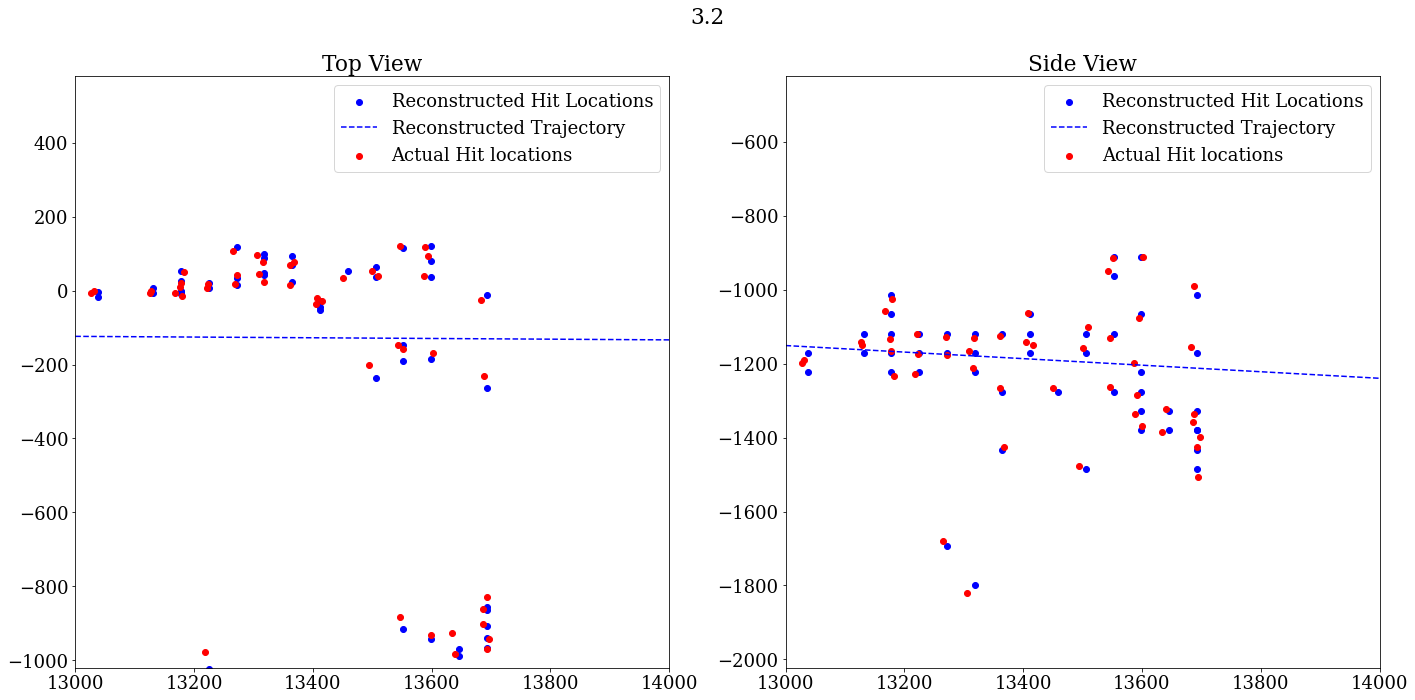

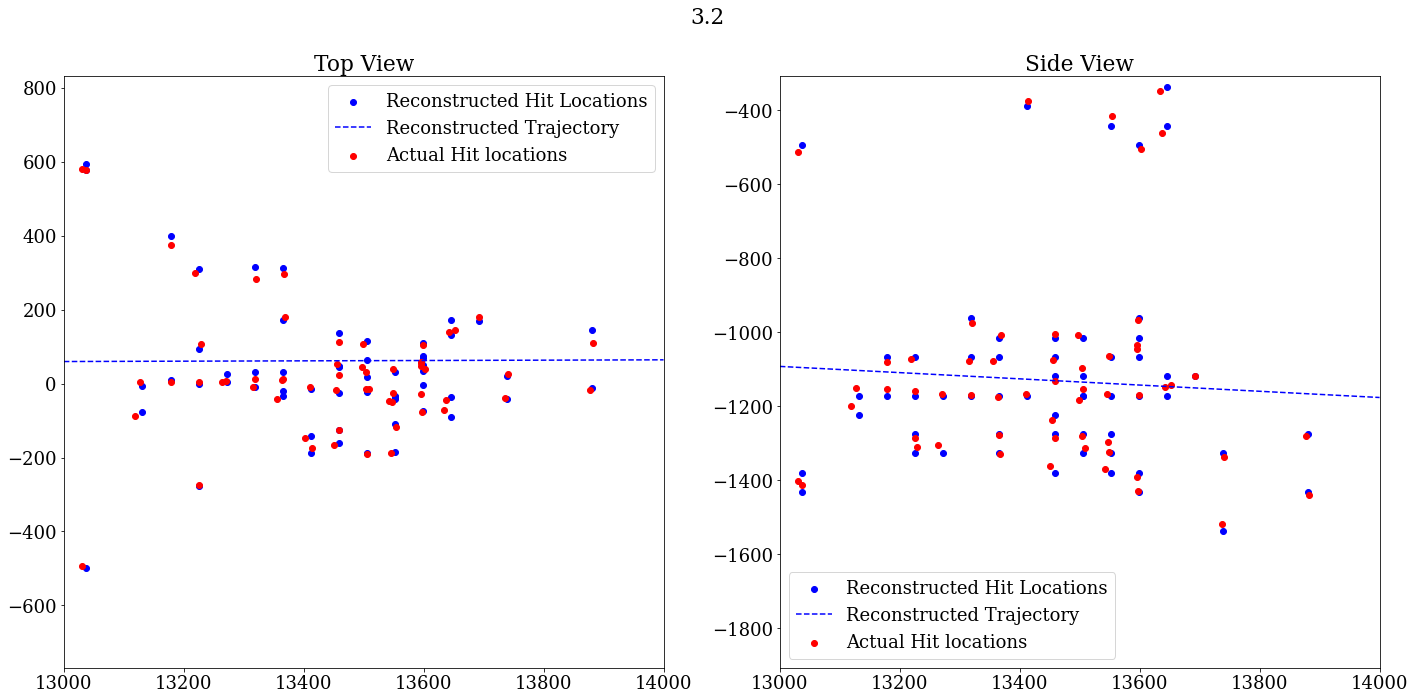

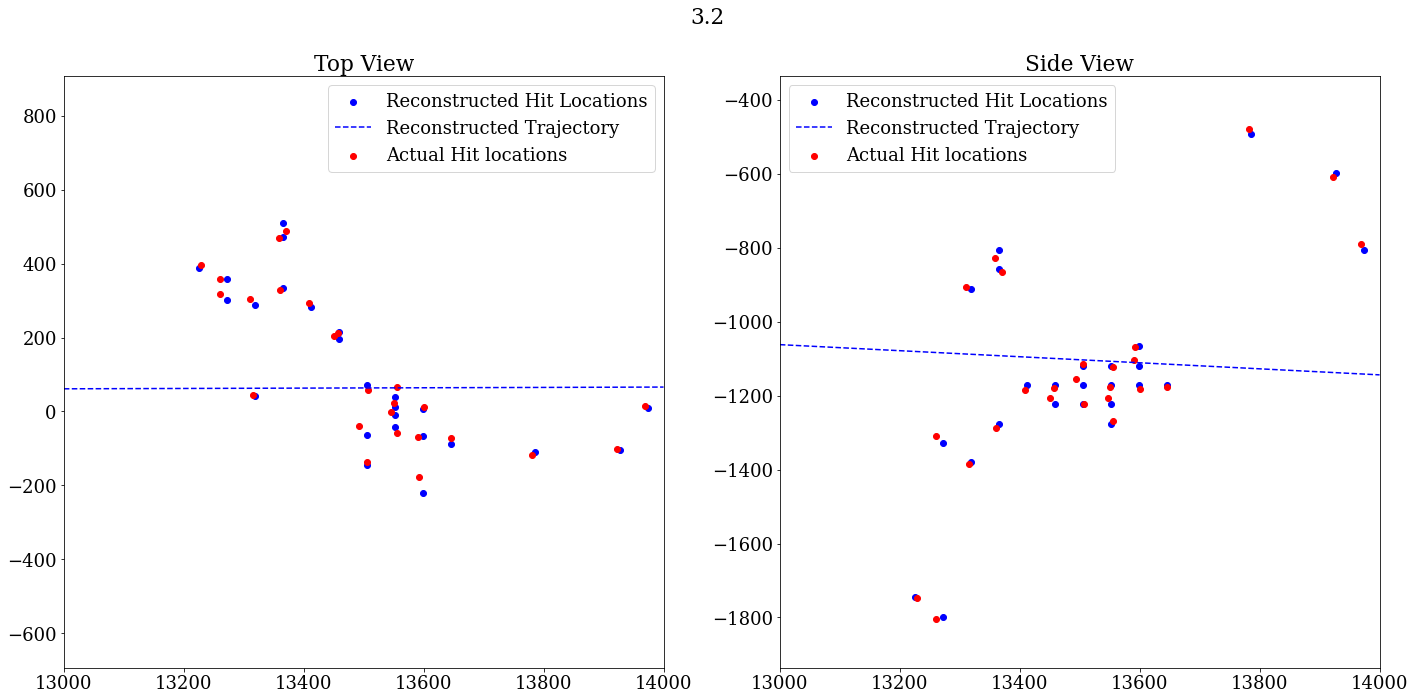

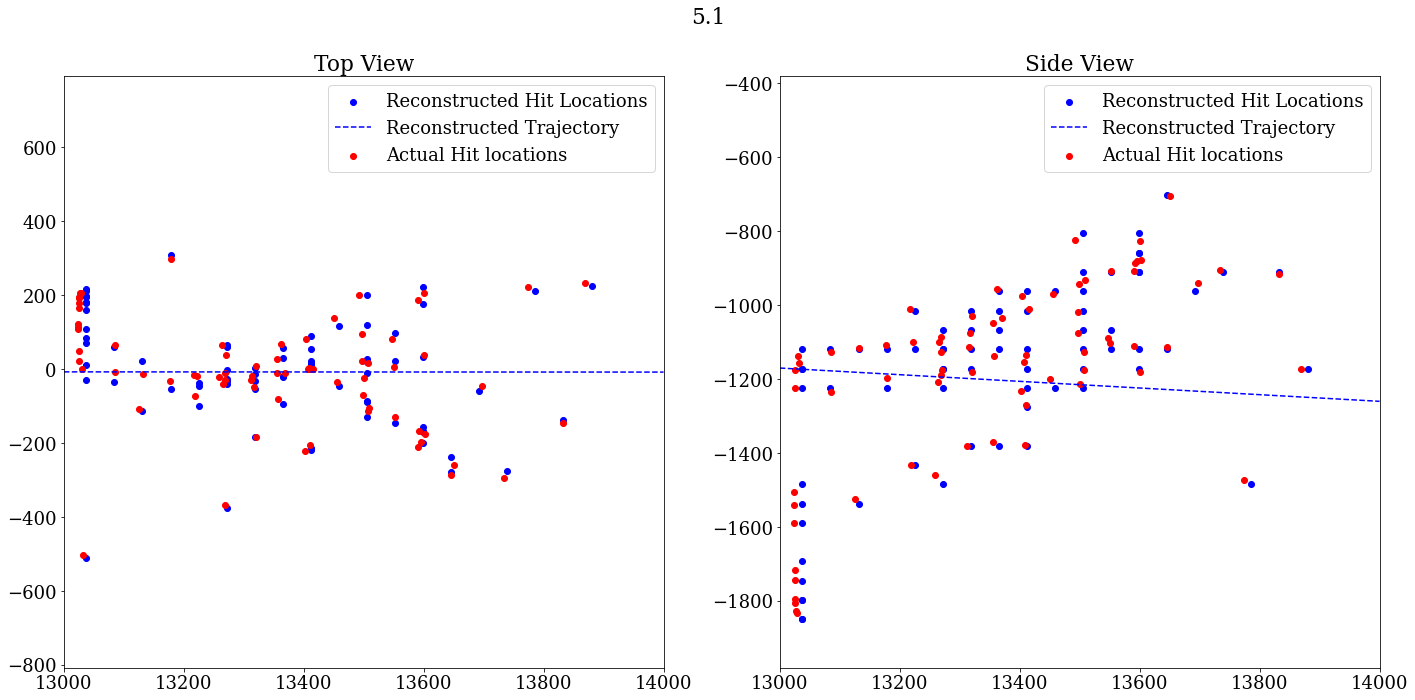

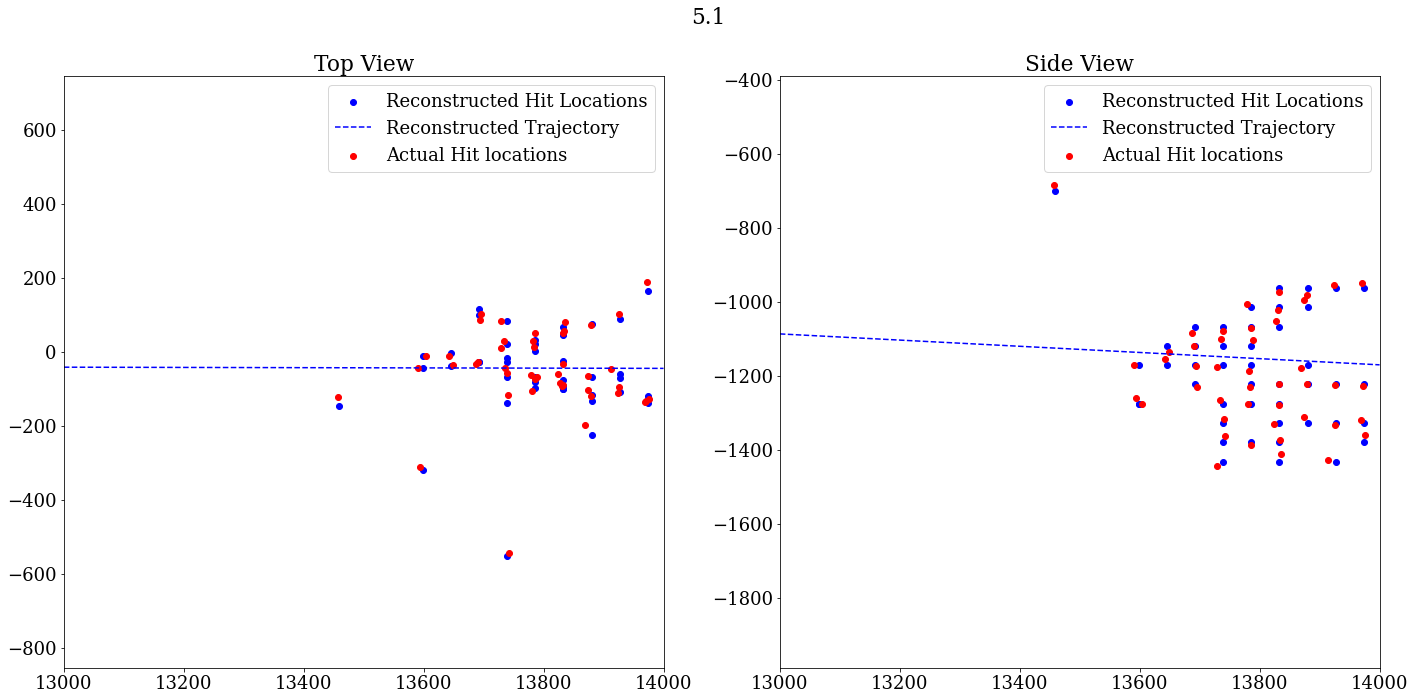

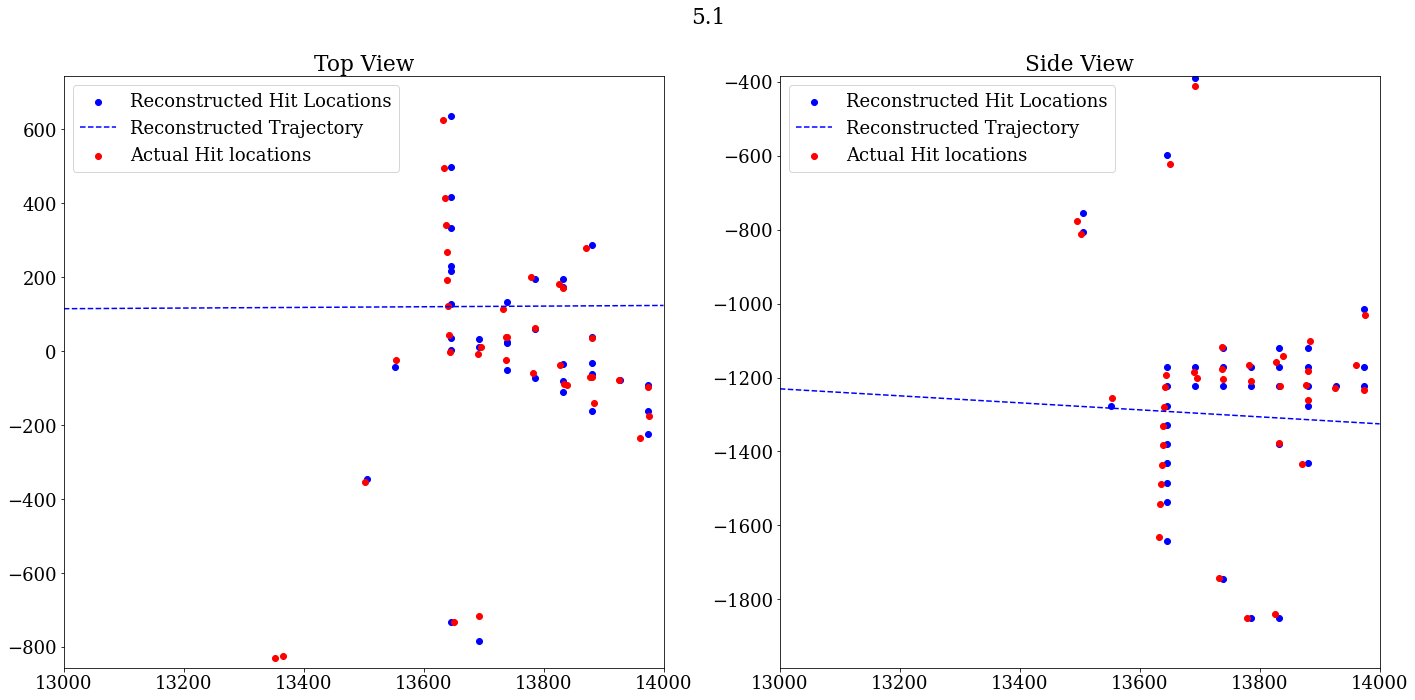

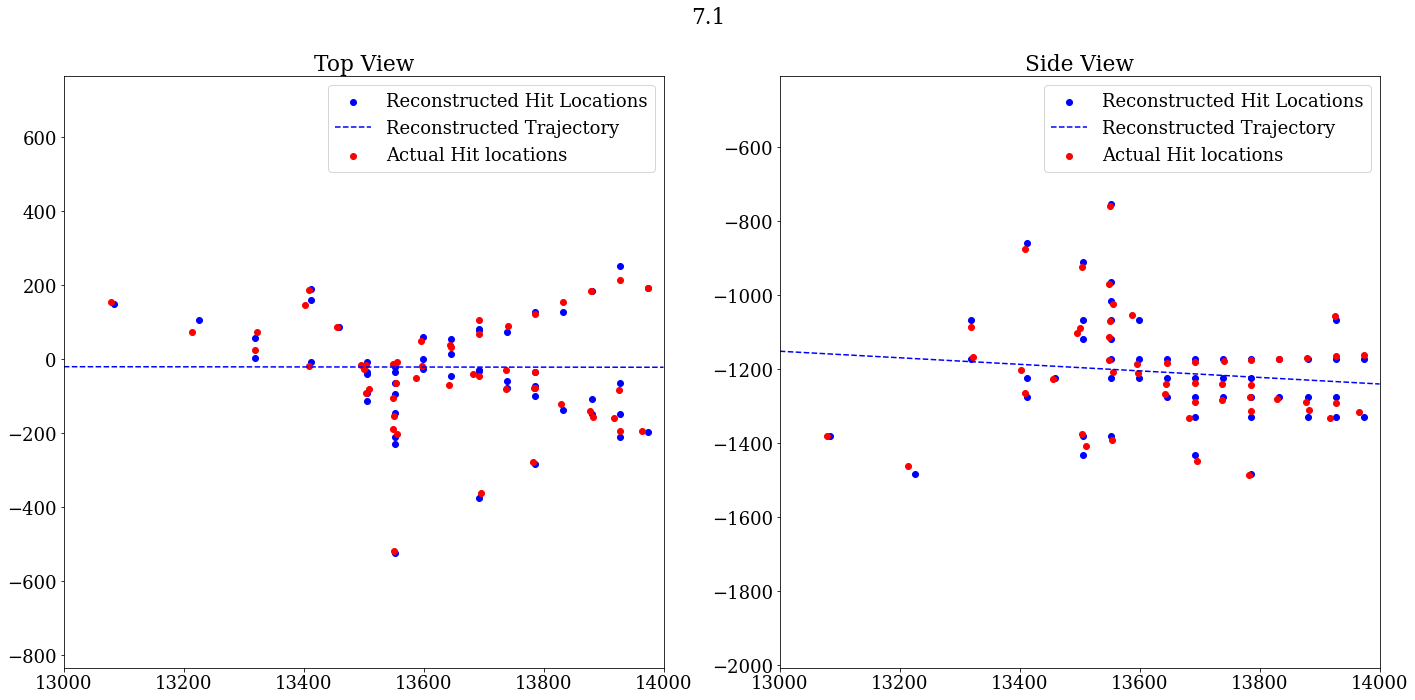

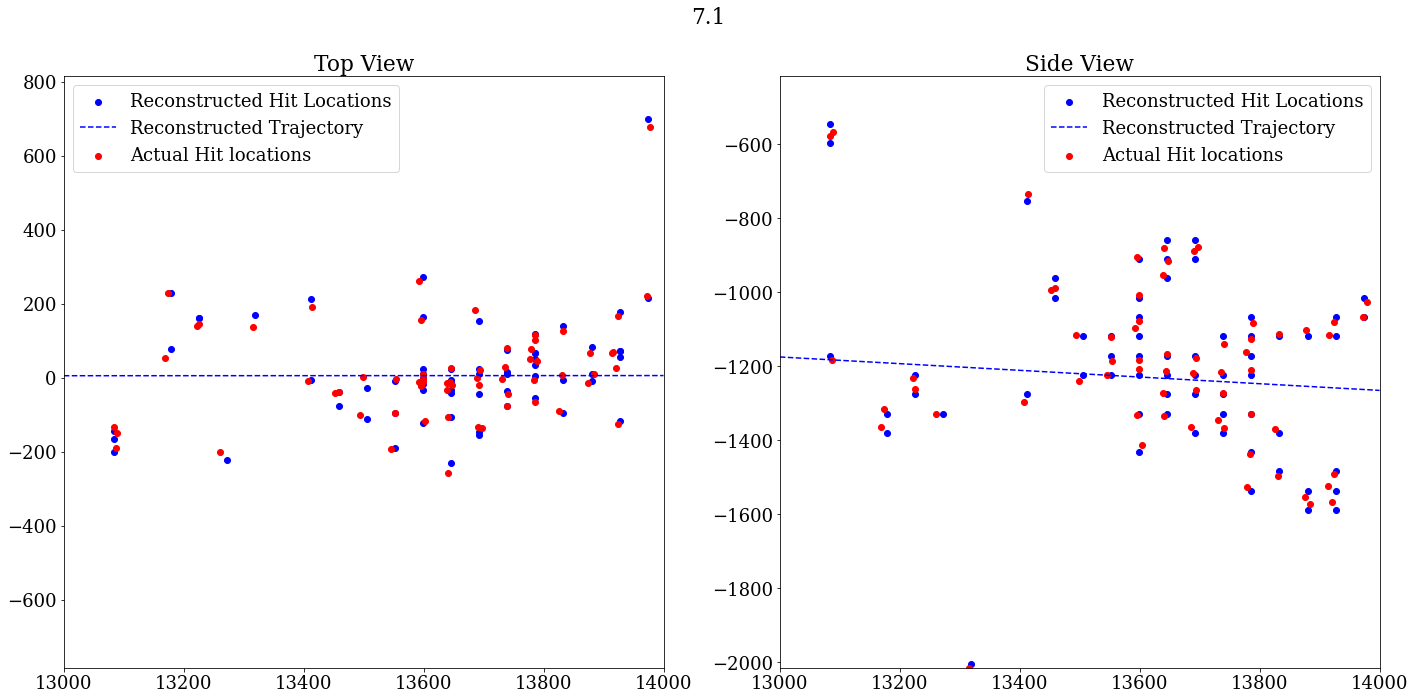

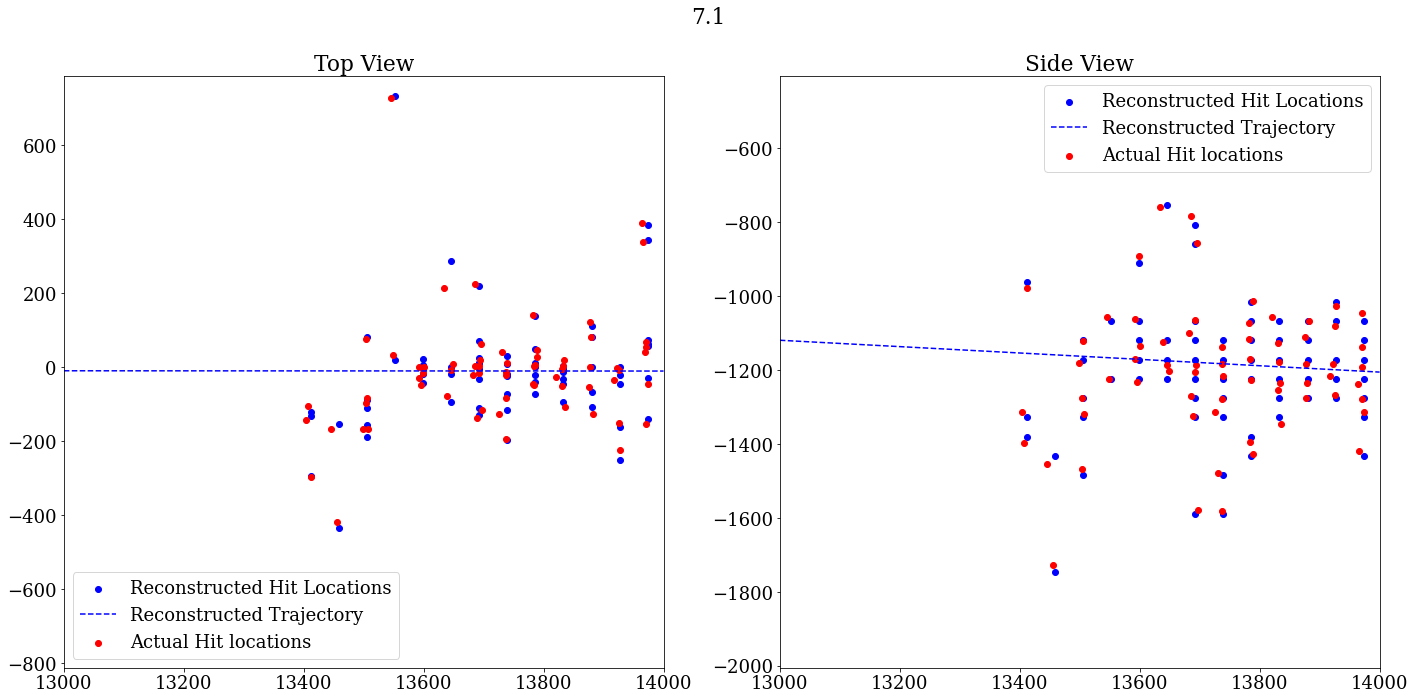

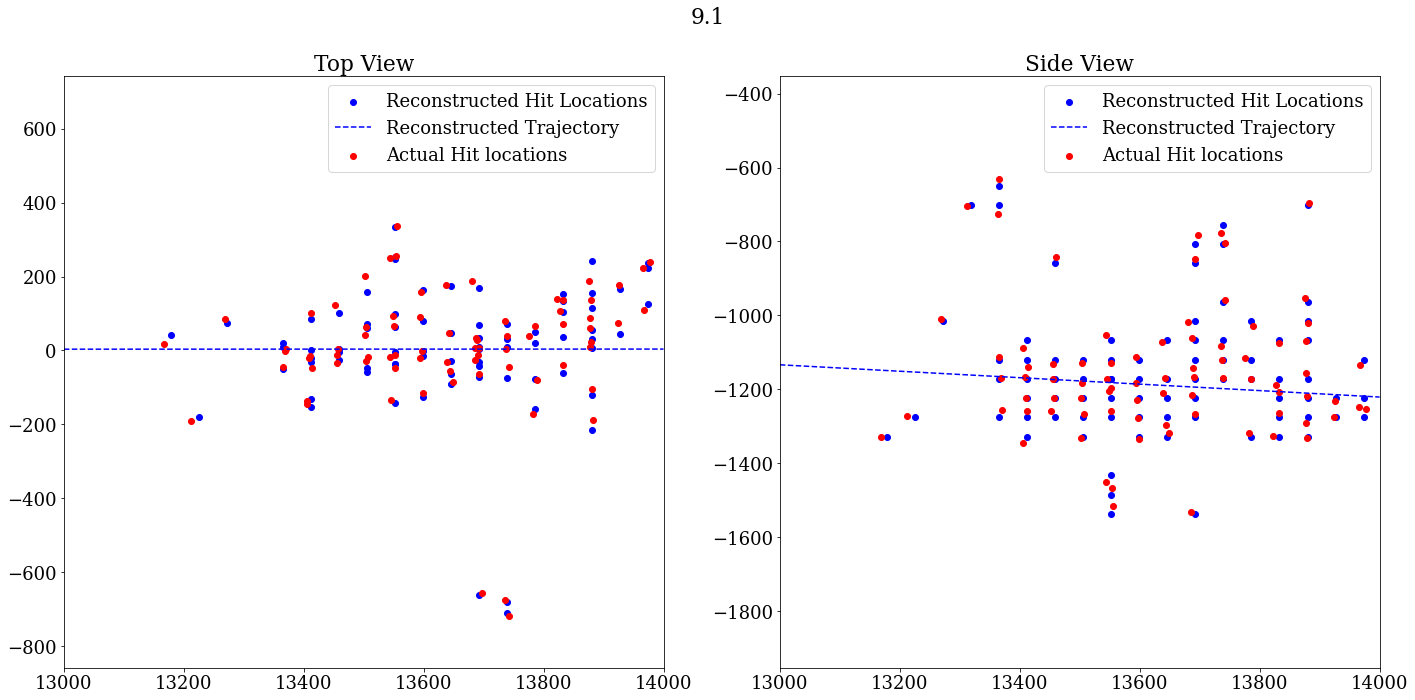

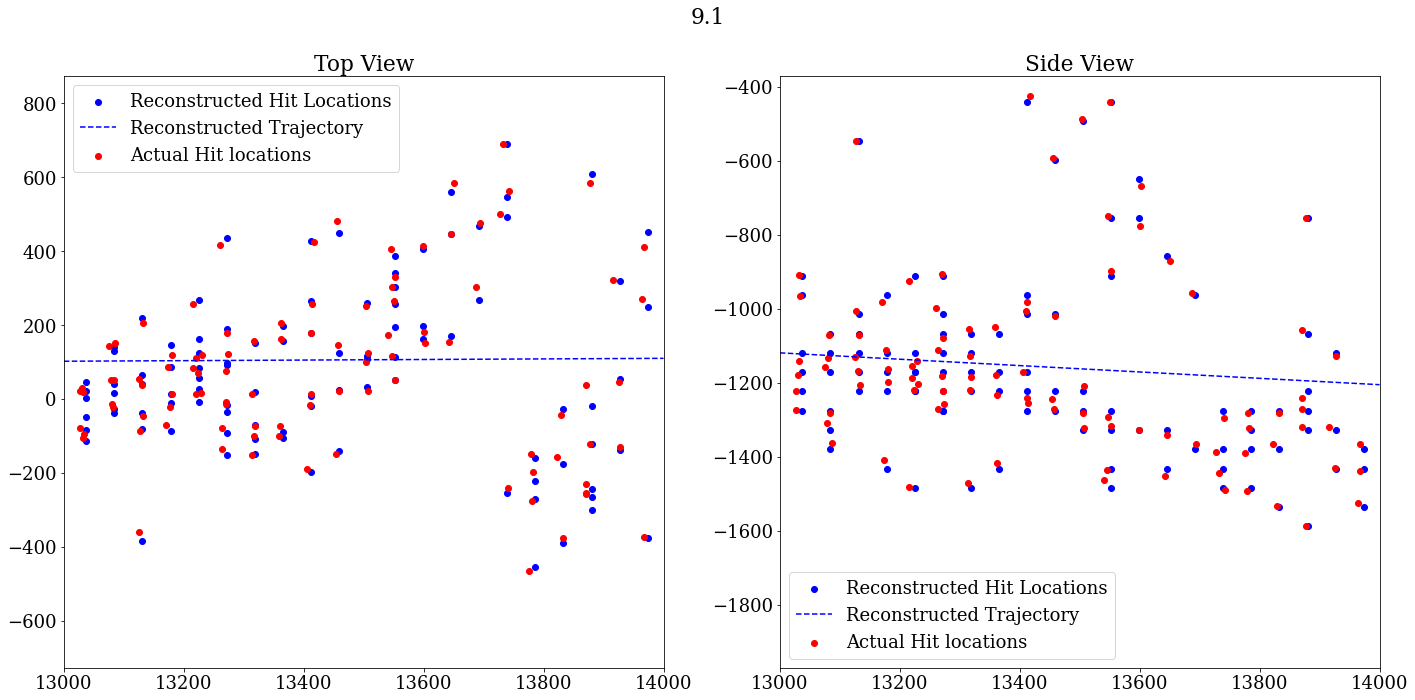

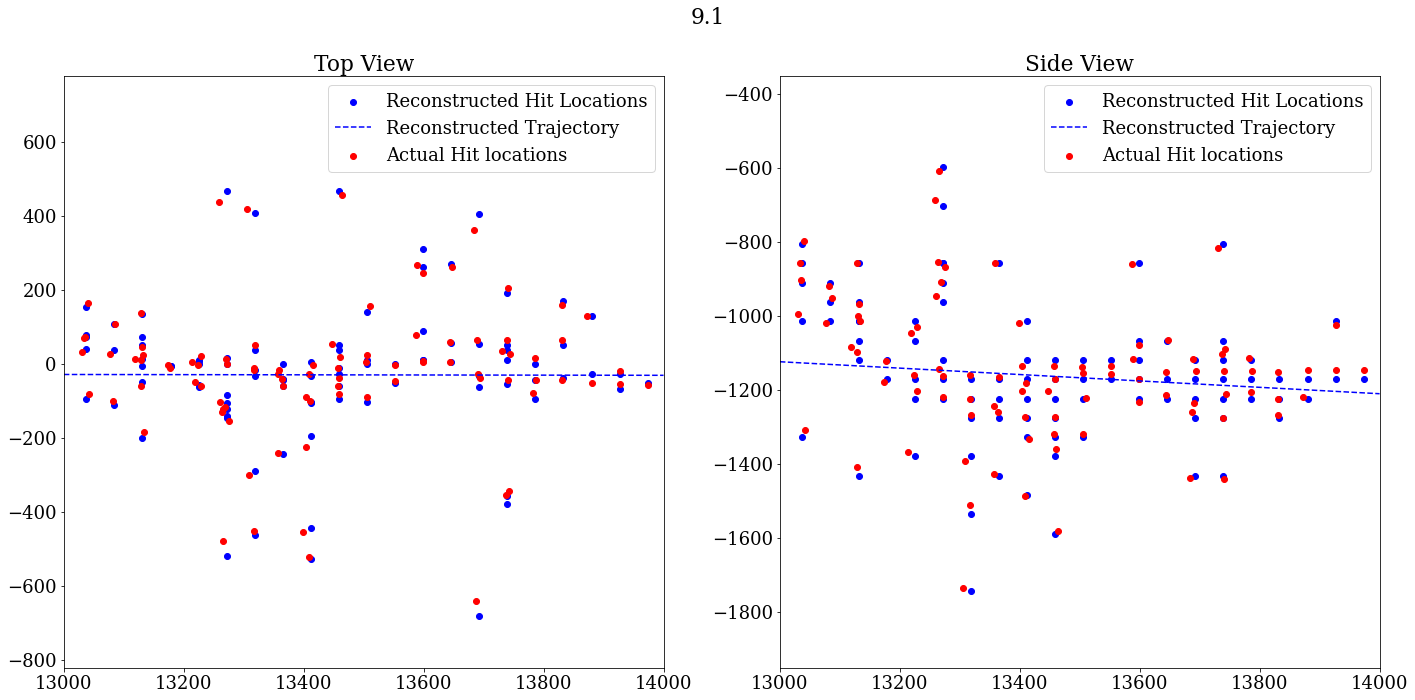

In [18]:
#for each event, take a weighted average of each hit's px/pz and py/pz relative to the origin

for i in range(len(nEnergies)):
    for eventnum in range(3):
        xs = results[i]['x_recon'][eventnum,:]
        ys = results[i]['y_recon'][eventnum,:]
        zs = results[i]['z_recon'][eventnum,:]
        As = ADCs[i][MIPcut[i]][hitscut[i]][eventnum,:]
        pxpz_hits = xs/zs
        pypz_hits = ys/zs
        pxpz = ak.mean(pxpz_hits,weight=As)
        pypz = ak.mean(pypz_hits,weight=As)
        
        #results[i]['px/pz hits'] = xs/zs
        #results[i]['py/pz hits'] = ys/zs
        #weight by product of amplitude and 1/residual or just the amplitude?
        #pxpz = ak.mean(results[i]['px/pz hits'],weight=As)

        #print(1/m_long,-b_long/m_long)
        xpt = pd.Series([13000, 14000])

        fig,ax = plt.subplots(1,2,figsize=(20,10))
        fig.suptitle(f"{nEnergies[i]}")
        ax[0].set_title("Top View")
        ax[0].scatter(zs,xs,color="blue",label="Reconstructed Hit Locations")
        
        ax[0].plot(xpt, xpt*pxpz, linestyle="--",color="blue",label="Reconstructed Trajectory")
        ax[0].scatter(avg_zs[i][MIPcut[i]][hitscut[i]][eventnum],avg_xs[i][MIPcut[i]][hitscut[i]][eventnum],color="red",label="Actual Hit locations")
        ax[0].set_xlim(13000,14000)
        ax[0].set_ylim(np.mean(xs)-800,np.mean(xs)+800)
        ax[0].legend()
        
        ax[1].set_title("Side View")
        ax[1].scatter(zs,ys,color="blue",label="Reconstructed Hit Locations")
        ax[1].plot(xpt, xpt*pypz, linestyle="--",color="blue",label="Reconstructed Trajectory")
        ax[1].scatter(avg_zs[i][MIPcut[i]][hitscut[i]][eventnum],avg_ys[i][MIPcut[i]][hitscut[i]][eventnum],color="red",label="Actual Hit locations")
        ax[1].set_xlim(13000,14000)
        ax[1].set_ylim(np.mean(ys)-800,np.mean(ys)+800)
        ax[1].legend()
        
        plt.show()
#plt.plot(avg_x_perlayer[0][0,:],
#layer = 1
#avg_x_perlayer[0][0]

In [19]:
#for each event, take a weighted average of each hit's px/pz and py/pz relative to the origin

for i in range(len(nEnergies)):
        xs = results[i]['x_recon']
        ys = results[i]['y_recon']
        zs = results[i]['z_recon']
        As = ADCs[i][MIPcut[i]][hitscut[i]]
        results[i]['px/pz hits'] = xs/zs
        results[i]['py/pz hits'] = ys/zs
        results[i]["px/pz"] = ak.mean(results[i]['px/pz hits'],weight=As,axis=1)
        results[i]["py/pz"] = ak.mean(results[i]['py/pz hits'],weight=As,axis=1)

        results[i]["px/pz_residual"] = results[i]["px/pz"] - ak.flatten(gpx[i][hitscut[i]]/gpz[i][hitscut[i]])

        results[i]["py/pz_residual"] = results[i]["py/pz"] - ak.flatten(gpy[i][hitscut[i]]/gpz[i][hitscut[i]])


In [20]:
results[0]

{'x_recon': <Array [[107, 382, -41, ... 213, 180, 391]] type='3696 * var * float64'>,
 'x_residual': <Array [[-19.9, 12.4, 16.4, ... -16.1, -0.881]] type='3696 * var * float64'>,
 'y_recon': <Array [[-1.17e+03, -1.17e+03, ... -1.38e+03]] type='3696 * var * float64'>,
 'y_residual': <Array [[-15.4, -12.2, -8.78, ... -7.18, -23]] type='3696 * var * float64'>,
 'z_recon': <Array [[1.35e+04, 1.36e+04, ... 1.36e+04]] type='3696 * var * float64'>,
 'z_residual': <Array [[-3.96, -4.09, -6.79, ... 2.34, -9.84]] type='3696 * var * float64'>,
 'px/pz hits': <Array [[0.00794, 0.0281, ... 0.0133, 0.0287]] type='3696 * var * float64'>,
 'py/pz hits': <Array [[-0.0867, -0.0861, ... -0.11, -0.101]] type='3696 * var * float64'>,
 'px/pz': <Array [0.004, 0.0309, ... 0.00986, 0.011] type='3696 * ?float64'>,
 'py/pz': <Array [-0.0864, -0.0948, ... -0.0923, -0.0901] type='3696 * ?float64'>,
 'px/pz_residual': <Array [0.004, 0.0309, ... 0.00986, 0.011] type='3696 * ?float64'>,
 'py/pz_residual': <Array [0.

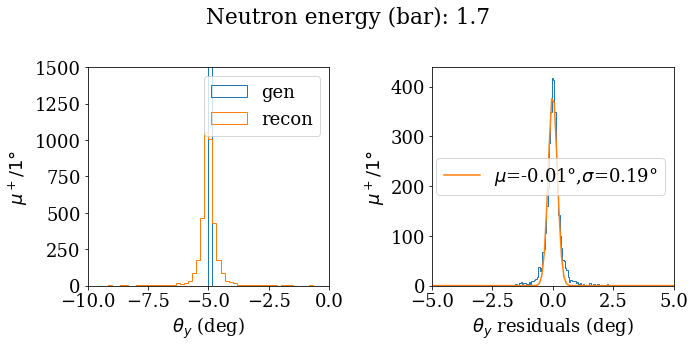

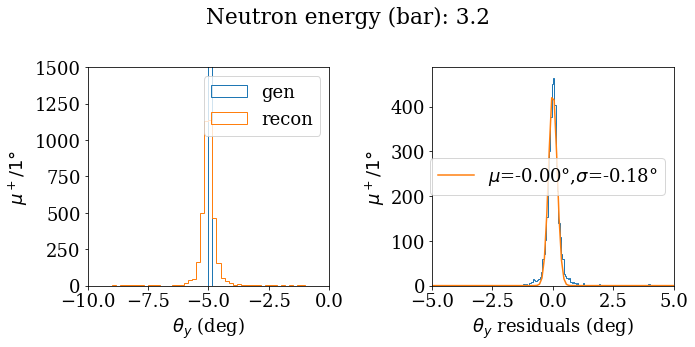

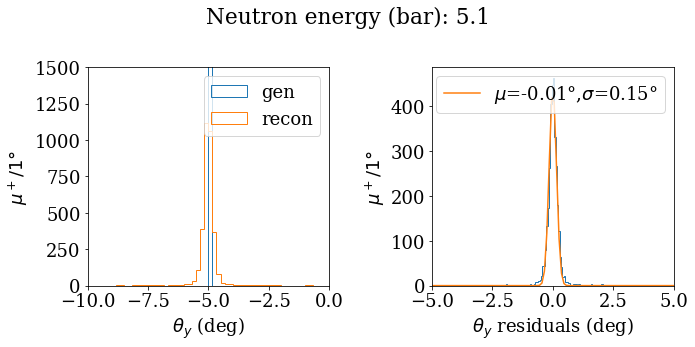

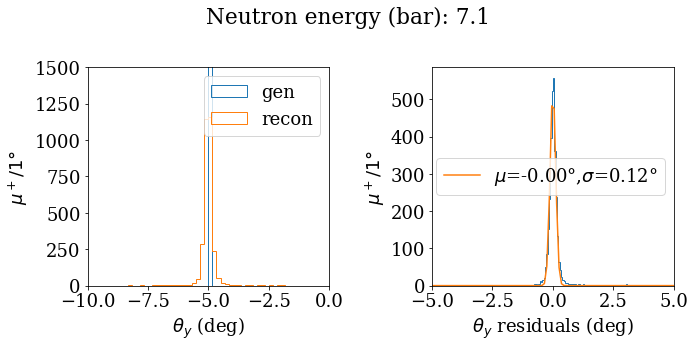

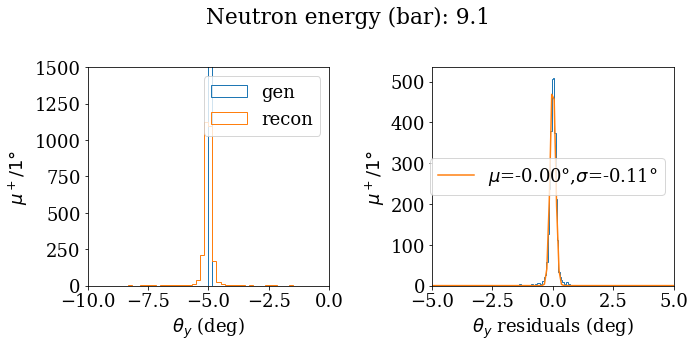

In [21]:
for i in range(len(nEnergies)):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(f"Neutron energy (bar): {nEnergies[i]}")
    ax[0].hist(np.arctan(gpy[i][hitscut[i]]/gpz[i][hitscut[i]])*180/np.pi,180,range=[-20,10],histtype="step",label="gen")
    ax[0].hist(np.arctan(results[i]["py/pz"])*180/np.pi,180,range=[-20,10],histtype="step",label="recon")
    ax[0].set_xlabel("$\\theta_y$ (deg)")
    ax[0].set_ylabel("$\\mu^+ /1°$")
    ax[0].set_xlim(-10,0)
    ax[0].set_ylim(0,1500)
    ax[0].legend()


    count,bins,bars = ax[1].hist(np.arctan(results[i]["py/pz"])*180/np.pi-np.arctan(gpy[i][hitscut[i]]/gpz[i][hitscut[i]])*180/np.pi,180,range=[-5,5],histtype="step")
    bincenters = 0.5*(bins[1:]+bins[:-1])
    coeff,covar = curve_fit(gaus, bincenters, count)#, sigma=np.sqrt(counts[countlist])
    ax[1].plot(np.linspace(-5,5,100),gaus(np.linspace(-5,5,100),*coeff),label=f"$\\mu$={coeff[1]:.2f}°,$\\sigma$={coeff[2]:.2f}°")
    ax[1].set_xlabel("$\\theta_y$ residuals (deg)")
    ax[1].set_ylabel("$\\mu^+ / 1°$")
    ax[1].legend()
    ax[1].set_xlim(-5,5)
    plt.show()

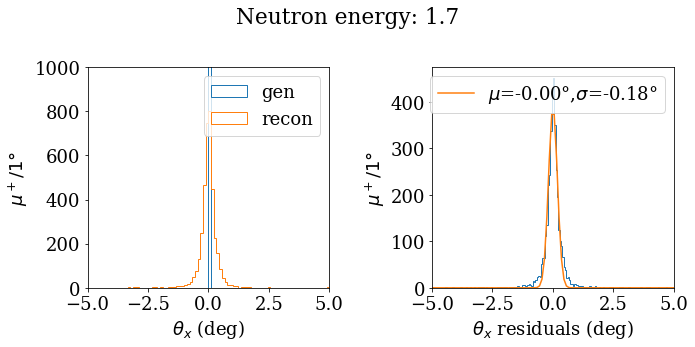

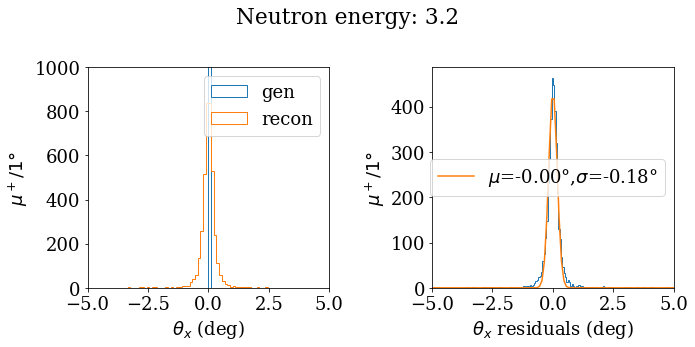

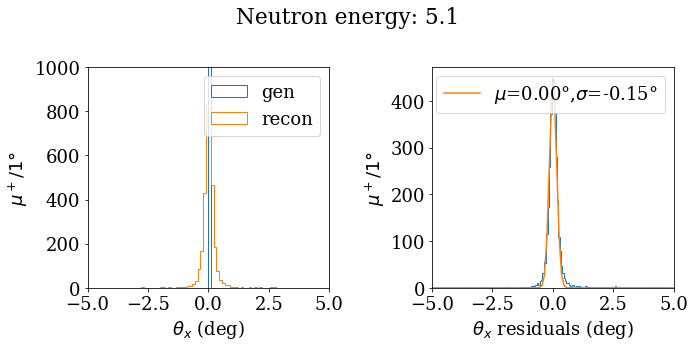

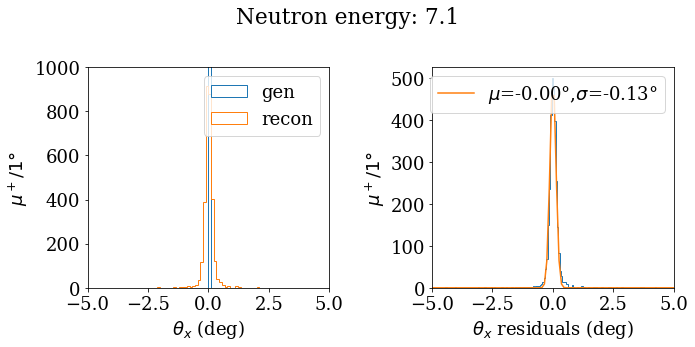

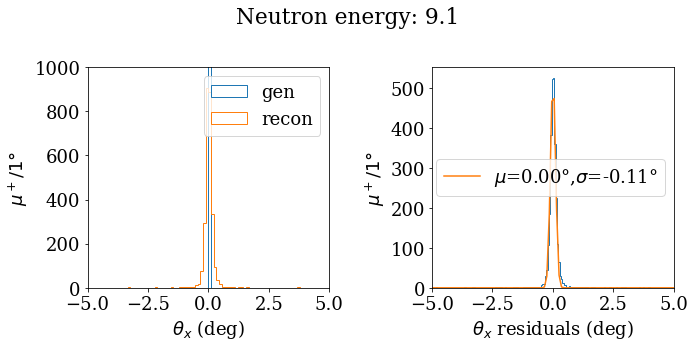

In [22]:
for i in range(len(nEnergies)):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(f"Neutron energy: {nEnergies[i]}")
    ax[0].hist(np.arctan(gpx[i][hitscut[i]]/gpz[i][hitscut[i]])*180/np.pi,180,range=[-10,10],histtype="step",label="gen")
    ax[0].hist(np.arctan(results[i]["px/pz"])*180/np.pi,180,range=[-10,10],histtype="step",label="recon")
    ax[0].set_xlabel("$\\theta_x$ (deg)")
    ax[0].set_ylabel("$\\mu^+ /1°$")
    ax[0].set_xlim(-5,5)
    ax[0].set_ylim(0,1000)
    ax[0].legend()


    count,bins,bars = ax[1].hist(np.arctan(results[i]["px/pz"])*180/np.pi-np.arctan(gpx[i][hitscut[i]]/gpz[i][hitscut[i]])*180/np.pi,180,range=[-5,5],histtype="step")
    bincenters = 0.5*(bins[1:]+bins[:-1])
    coeff,covar = curve_fit(gaus, bincenters, count)#, sigma=np.sqrt(counts[countlist])
    ax[1].plot(np.linspace(-5,5,100),gaus(np.linspace(-5,5,100),*coeff),label=f"$\\mu$={coeff[1]:.2f}°,$\\sigma$={coeff[2]:.2f}°")
    ax[1].set_xlabel("$\\theta_x$ residuals (deg)")
    ax[1].set_ylabel("$\\mu^+ / 1°$")
    ax[1].legend()
    ax[1].set_xlim(-5,5)
    plt.show()

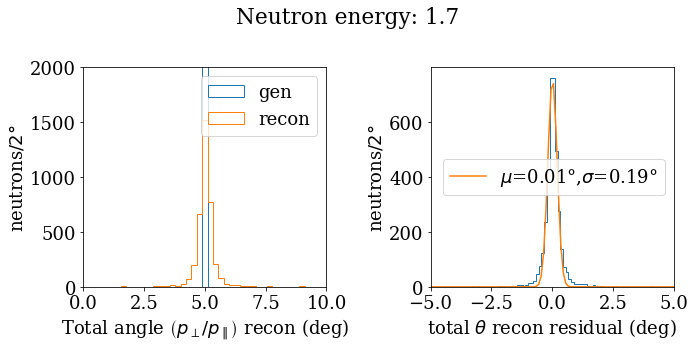

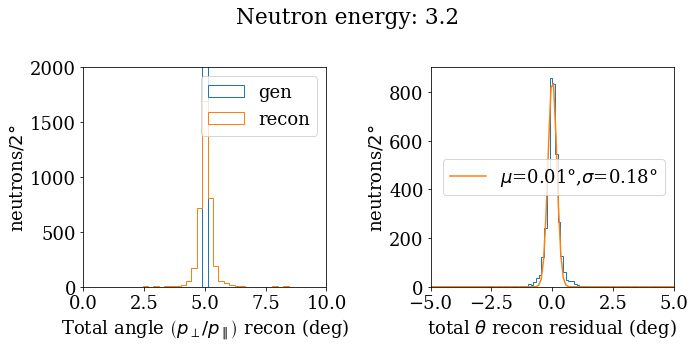

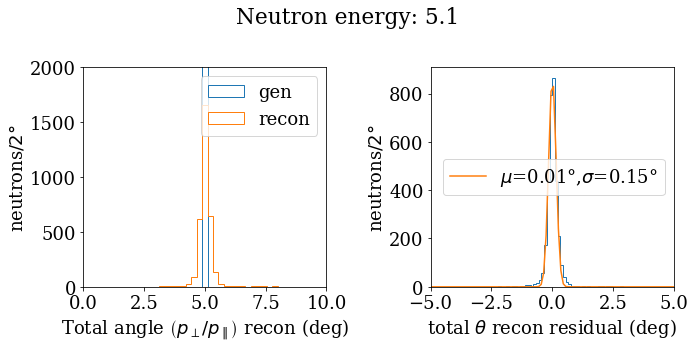

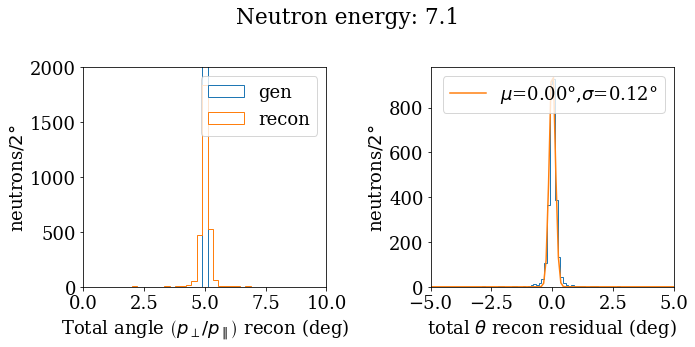

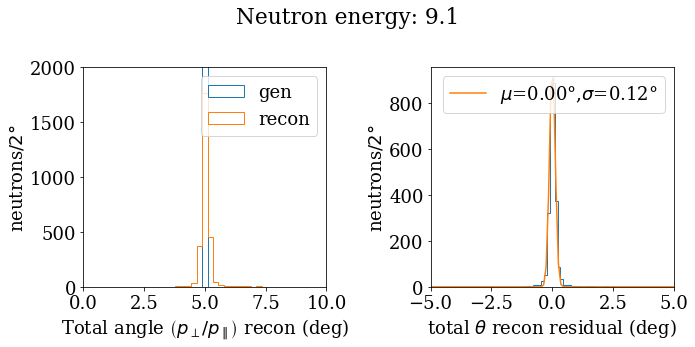

In [23]:
for i in range(len(nEnergies)):
    
    pr_pz = np.sqrt(np.power(results[i]["py/pz"],2)+np.power(results[i]["px/pz"],2))
    genpr_pz = np.sqrt(np.power(gpy[i][hitscut[i]],2)+np.power(gpx[i][hitscut[i]],2))/gpz[i][hitscut[i]]                

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(f"Neutron energy: {nEnergies[i]}")
    ax[0].hist(np.arctan(genpr_pz)*180/np.pi,90,range=[0,20],histtype="step",label="gen")
    ax[0].hist(np.arctan(pr_pz)*180/np.pi,90,range=[0,20],histtype="step",label="recon")
    ax[0].set_xlabel("Total angle $\\left(p_\\perp / p_\\parallel\\right)$ recon (deg)")
    ax[0].set_ylabel("neutrons$/2°$")
    ax[0].set_xlim(0,10)
    ax[0].set_ylim(0,2000)
    ax[0].legend()


    count,bins,bars = ax[1].hist(np.arctan(pr_pz)*180/np.pi-np.arctan(genpr_pz)*180/np.pi,90,range=[-5,5],histtype="step")
    bincenters = 0.5*(bins[1:]+bins[:-1])
    coeff,covar = curve_fit(gaus, bincenters, count)#, sigma=np.sqrt(counts[countlist])
    ax[1].plot(np.linspace(-5,5,100),gaus(np.linspace(-5,5,100),*coeff),label=f"$\\mu$={coeff[1]:.2f}°,$\\sigma$={abs(coeff[2]):.2f}°")
    ax[1].set_xlabel("total $\\theta$ recon residual (deg)")
    ax[1].set_ylabel("neutrons$/ 2°$")
    ax[1].legend()
    ax[1].set_xlim(-5,5)
    plt.show()